# Detecting Multimodal AUC distributions in HNSCC 

We currently assign sensitivities by tail-assignment, however, there may be cases with distinctive multimodal distributions that are indicative of different response models. 

We'll begin by testing the method on beatAML data where we have much greater number of observations, and therefore more well defined distributions. 

$$ p(x) = \frac{1}{\sqrt{ 2 \pi \sigma^2 }} e^{ - \frac{ (x - \mu)^2 } {2 \sigma^2} } $$

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd 
import numpy as np
from sklearn.mixture import GMM
import seaborn as sbn
from matplotlib import pyplot as plt
import warnings

# ------ for mut models ---------
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
import statsmodels.api as sm
from sklearn import metrics

warnings.filterwarnings("ignore")

In [12]:
# import jtplot module in notebook
from jupyterthemes import jtplot

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(theme='onedork')

In [4]:
aml_aucs = pd.read_csv('./../beatAML_data/beatAML_aucs.csv')[['inhibitor','lab_id','auc']].drop_duplicates()

#aml_aucs = pd.read_csv('./../data/beatAML_AUCs_subset.csv')

In [5]:
aml_aucs.head()

inhibitor    lab_id         auc
0   17-AAG (Tanespimycin)  12-00211  225.918025
7   17-AAG (Tanespimycin)  12-00219  135.264409
14  17-AAG (Tanespimycin)  12-00258  164.561227
21  17-AAG (Tanespimycin)  12-00262  111.555971
28  17-AAG (Tanespimycin)  12-00268  226.805281

In [6]:
def add_normal_plot(mu, s, weight, c, ax, auc_max=300): 
    '''
    mu = mean
    s = standard deviation
    ax = matplotlib axes to add to 
    c = color {[r b g c y ...]} <str> 
    '''
    
    x = np.arange(0, auc_max, 1)
    y = (1/(2*np.pi*s**2)**(0.5))*np.exp( - (x-mu)**2/(2*s**2) ) * weight
    
    ax = ax.plot(x,y, color=c, label='mean: %.1f, std: %.1f' %(mu, s))

def get_color():
    '''
    
    '''
    for c in ['r','b','g','c','y']: 
        yield c
    

In [7]:
gen = get_color()
gen.__next__()

'r'

In [8]:
def test_multimodal_fits(X, ntests=10, kmax=5, plot=True, inhib=None, override_k=False): 
    '''
    
    '''
    
    res = {x:[] for x in ['k', 'aic', 'bic']}
    for k in range(1,kmax): 
        for i in range(ntests): 
            
            #print('k: %d' %k)
            gmm = GMM(n_components=k, n_init=1)
            gmm.fit(X)
            res['k'].append( k )
            res['aic'].append( gmm.aic(X) )
            res['bic'].append( gmm.bic(X) )
            
    res = pd.DataFrame( res )
    
    best_k = res[res.bic == np.min(res.bic)].k.unique()[0] if not override_k else override_k
    gmm_best = GMM(n_components=best_k,n_init=20) 
    gmm_best.fit(X)
    P = gmm_best.predict(X)
    
    if plot:         
        nbins = 50
        bin_ = np.arange(0,np.max(X),np.max(X)/nbins)
        
        scalar_to_make_pretty = 0.25 # since our fitted Gaussians are normalized to their weights, they appear smaller
        weights_ = scalar_to_make_pretty/len(X)
        
        f, axs = plt.subplots(1,3,figsize=(15,5)) 
        sbn.distplot(X, bins=bin_, ax=axs[0]).set_title('AUC distribution')
        sbn.scatterplot(x='k', y='bic', alpha=0.3, data=res, ax=axs[1]).set_title('BIC vs K')
        
        clas = 0
        for weight, mean, covars, c in zip(gmm_best.weights_, gmm_best.means_, gmm_best.covars_, get_color()): 
            sbn.distplot(X[P==clas], bins=bin_, kde=False, color=c, ax=axs[2], label='AUC', hist_kws={'weights': [weights_]*len(X[P==clas])})
            add_normal_plot(mean[0], (covars[0])**0.5, weight, c, axs[2], auc_max=np.max(X))
            clas+=1
        
        axs[2].set_title('Optimal GMM fit')
        
        plt.legend()
        plt.suptitle(inhib)
        
        print('Number of assays (aucs): %d' %len(X))
        print('Optimal K: %d [BIC=%.1f]' %(best_k, np.min(res.bic)))
        print('GMM fit:\n\tMixture Weights: %r\n\tMeans: %r\n\tVariances: %r' %(gmm_best.weights_.ravel(), gmm_best.means_.ravel(), gmm_best.covars_.ravel()))
        print('Class counts: %r' %['class %d: %d' %(cl, len(X[P==cl])) for cl in list(set(P))])
        
        plt.show()
        
    return P


------------------------------------------------
Inhibitor:  Axitinib (AG-013736)
------------------------------------------------
Number of assays (aucs): 489
Optimal K: 1 [BIC=5142.2]
GMM fit:
	Mixture Weights: array([1.])
	Means: array([196.08068388])
	Variances: array([2105.86622831])
Class counts: ['class 0: 489']


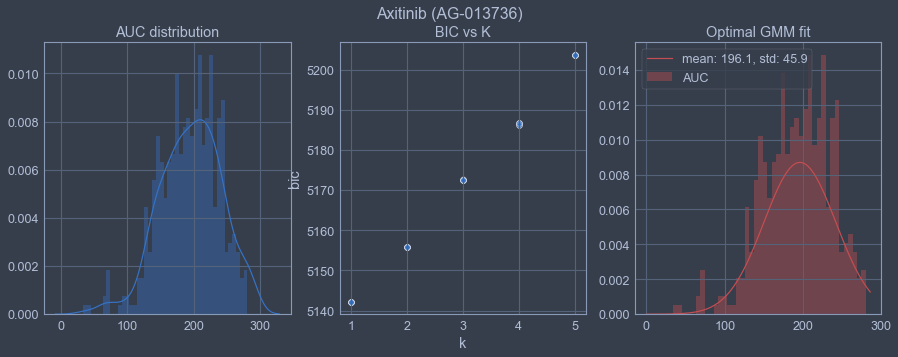

------------------------------------------------
Inhibitor:  Crizotinib (PF-2341066)
------------------------------------------------
Number of assays (aucs): 497
Optimal K: 1 [BIC=5065.6]
GMM fit:
	Mixture Weights: array([1.])
	Means: array([204.51331279])
	Variances: array([1524.50444563])
Class counts: ['class 0: 497']


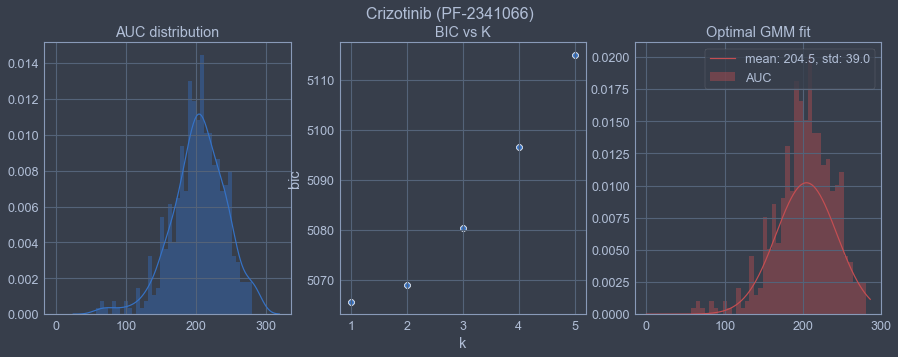

------------------------------------------------
Inhibitor:  Dasatinib
------------------------------------------------
Number of assays (aucs): 500
Optimal K: 2 [BIC=5491.2]
GMM fit:
	Mixture Weights: array([0.53217975, 0.46782025])
	Means: array([217.77686359, 123.55335351])
	Variances: array([1257.28478297, 1388.06017329])
Class counts: ['class 0: 276', 'class 1: 224']


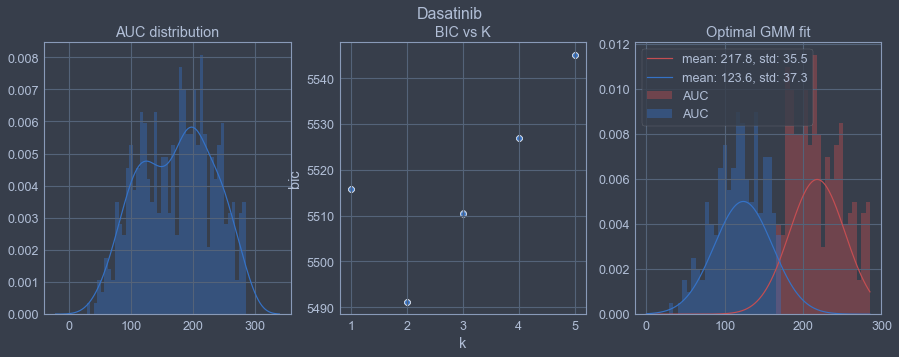

------------------------------------------------
Inhibitor:  Erlotinib
------------------------------------------------
Number of assays (aucs): 494
Optimal K: 2 [BIC=4859.8]
GMM fit:
	Mixture Weights: array([0.61664257, 0.38335743])
	Means: array([245.32512682, 206.5011893 ])
	Variances: array([ 453.23643433, 1367.04298121])
Class counts: ['class 0: 358', 'class 1: 136']


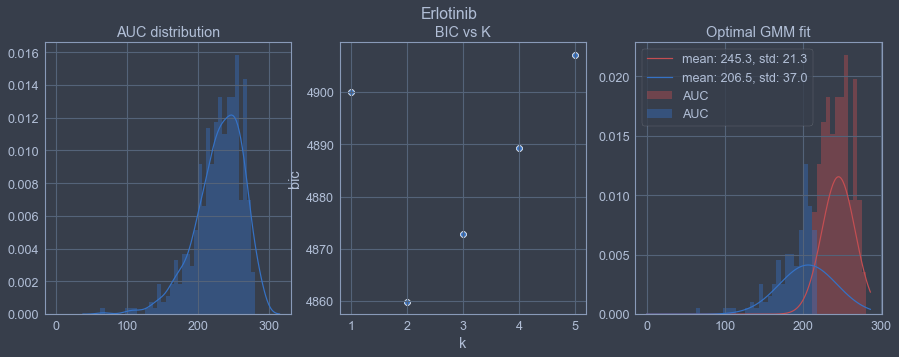

------------------------------------------------
Inhibitor:  Gefitinib
------------------------------------------------
Number of assays (aucs): 492
Optimal K: 2 [BIC=4781.7]
GMM fit:
	Mixture Weights: array([0.33129258, 0.66870742])
	Means: array([216.04175397, 253.3594795 ])
	Variances: array([1573.84847907,  403.86181731])
Class counts: ['class 0: 102', 'class 1: 390']


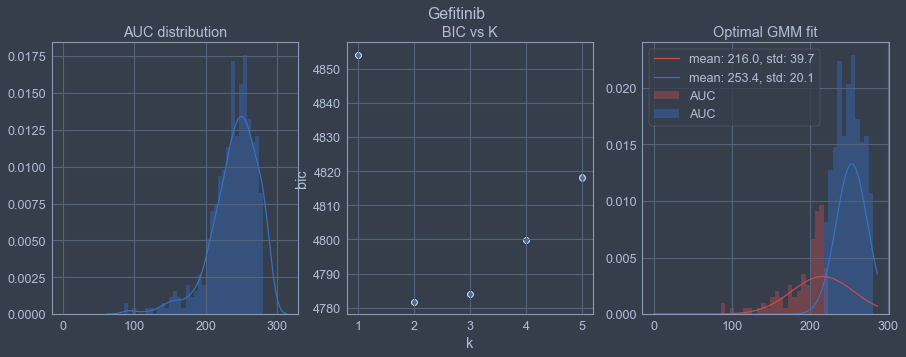

------------------------------------------------
Inhibitor:  Imatinib
------------------------------------------------
Number of assays (aucs): 511
Optimal K: 3 [BIC=5165.5]
GMM fit:
	Mixture Weights: array([0.43545984, 0.13128803, 0.43325213])
	Means: array([252.6459565 , 172.61882634, 227.41765714])
	Variances: array([ 470.01793071, 3189.19280153,  881.99645221])
Class counts: ['class 0: 275', 'class 1: 40', 'class 2: 196']


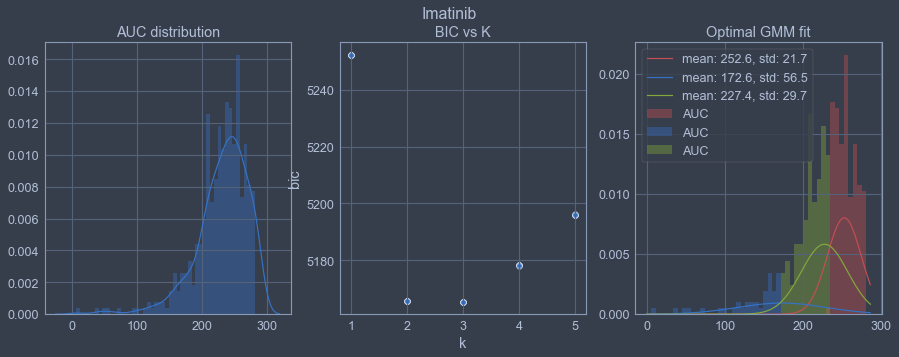

------------------------------------------------
Inhibitor:  Lapatinib
------------------------------------------------
Number of assays (aucs): 485
Optimal K: 2 [BIC=4735.0]
GMM fit:
	Mixture Weights: array([0.37159515, 0.62840485])
	Means: array([212.13786003, 243.08928529])
	Variances: array([1530.34760838,  455.4886863 ])
Class counts: ['class 0: 101', 'class 1: 384']


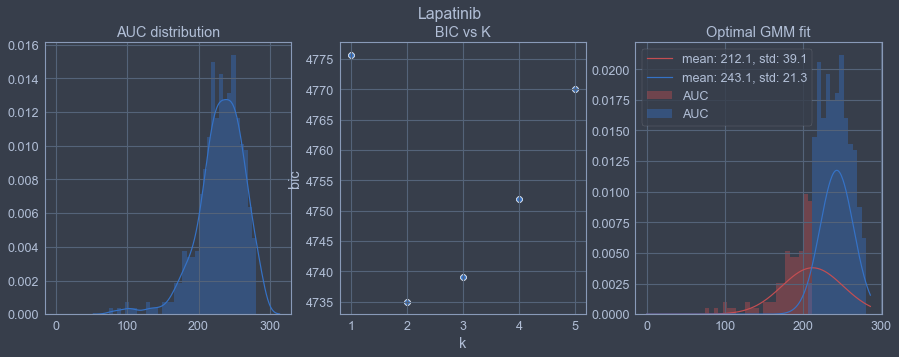

------------------------------------------------
Inhibitor:  Nilotinib
------------------------------------------------
Number of assays (aucs): 495
Optimal K: 2 [BIC=5019.3]
GMM fit:
	Mixture Weights: array([0.49843481, 0.50156519])
	Means: array([255.37294147, 199.69481155])
	Variances: array([ 463.14206147, 1000.14457906])
Class counts: ['class 0: 258', 'class 1: 237']


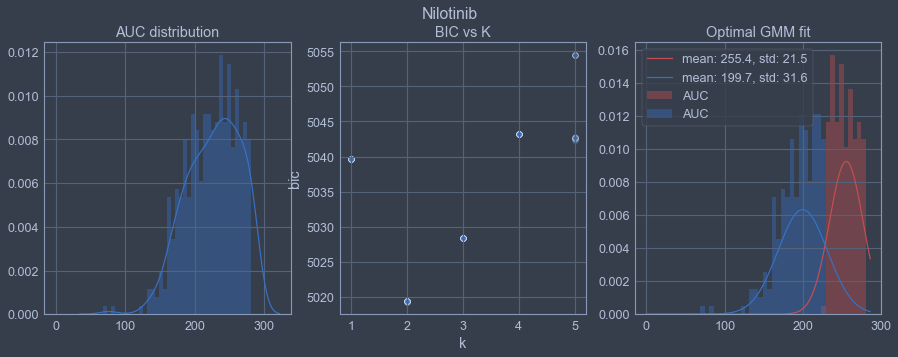

------------------------------------------------
Inhibitor:  Pazopanib (GW786034)
------------------------------------------------
Number of assays (aucs): 486
Optimal K: 2 [BIC=5087.4]
GMM fit:
	Mixture Weights: array([0.56246155, 0.43753845])
	Means: array([237.73450149, 188.62149669])
	Variances: array([ 926.376757  , 2163.34416825])
Class counts: ['class 0: 324', 'class 1: 162']


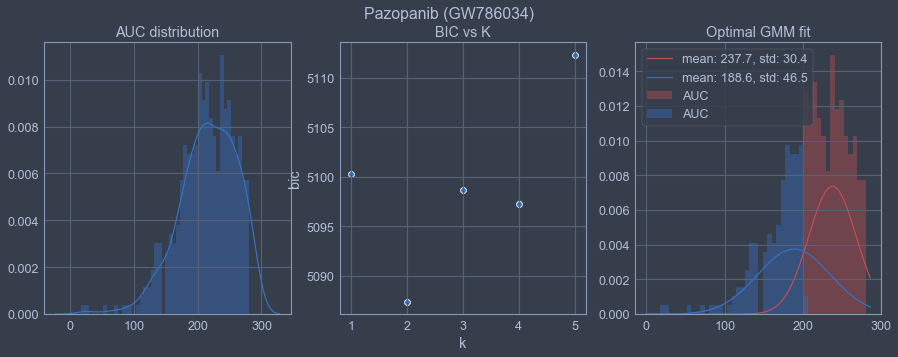

------------------------------------------------
Inhibitor:  Ponatinib (AP24534)
------------------------------------------------
Number of assays (aucs): 460
Optimal K: 2 [BIC=5002.3]
GMM fit:
	Mixture Weights: array([0.4789037, 0.5210963])
	Means: array([193.48173313, 113.26869384])
	Variances: array([1604.4604425 , 1281.09410219])
Class counts: ['class 0: 212', 'class 1: 248']


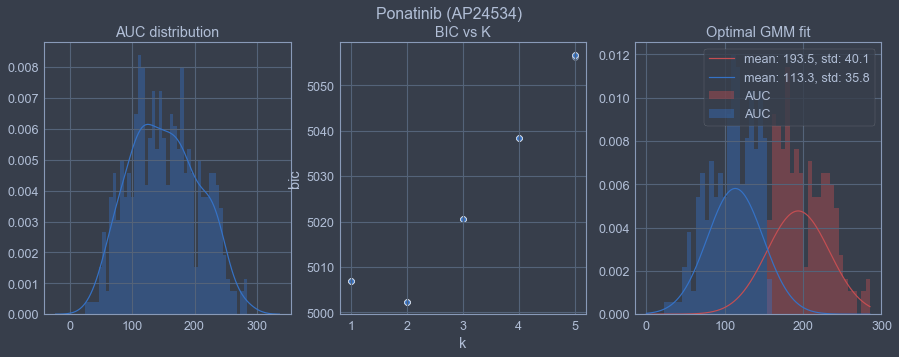

------------------------------------------------
Inhibitor:  Rapamycin
------------------------------------------------
Number of assays (aucs): 478
Optimal K: 1 [BIC=5206.2]
GMM fit:
	Mixture Weights: array([1.])
	Means: array([175.98806926])
	Variances: array([3065.14456621])
Class counts: ['class 0: 478']


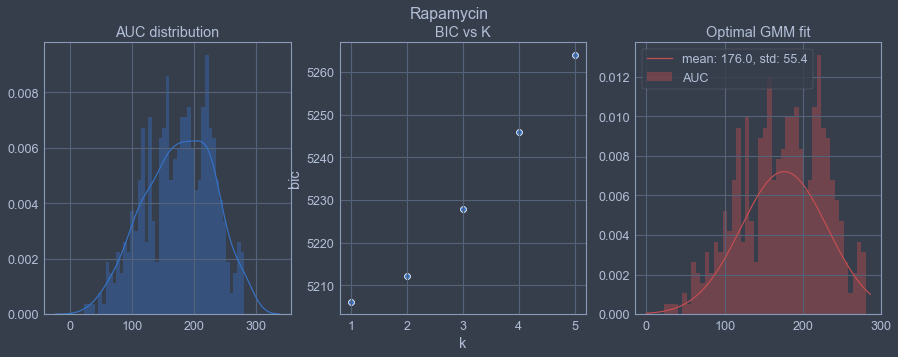

------------------------------------------------
Inhibitor:  Ruxolitinib (INCB018424)
------------------------------------------------
Number of assays (aucs): 475
Optimal K: 3 [BIC=4700.5]
GMM fit:
	Mixture Weights: array([0.47605634, 0.44450288, 0.07944077])
	Means: array([220.15762164, 258.90372332, 174.7215596 ])
	Variances: array([ 509.02343414,  339.18182279, 2042.03146949])
Class counts: ['class 0: 232', 'class 1: 222', 'class 2: 21']


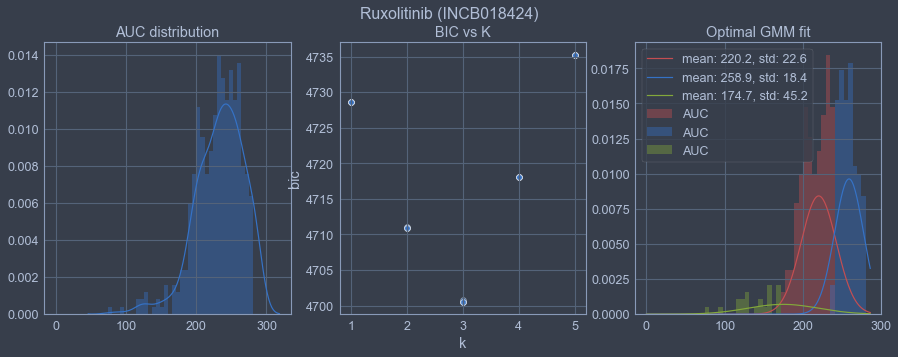

------------------------------------------------
Inhibitor:  Sorafenib
------------------------------------------------
Number of assays (aucs): 505
Optimal K: 2 [BIC=5406.4]
GMM fit:
	Mixture Weights: array([0.42476075, 0.57523925])
	Means: array([160.43097496, 220.70232329])
	Variances: array([2577.01244736, 1141.4331894 ])
Class counts: ['class 0: 173', 'class 1: 332']


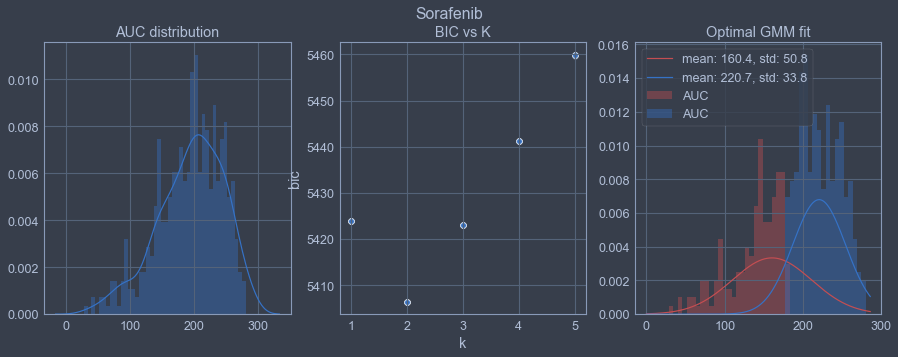

------------------------------------------------
Inhibitor:  Sunitinib
------------------------------------------------
Number of assays (aucs): 501
Optimal K: 2 [BIC=5264.8]
GMM fit:
	Mixture Weights: array([0.56875223, 0.43124777])
	Means: array([225.67490839, 170.94741204])
	Variances: array([ 950.86260094, 2018.09015565])
Class counts: ['class 0: 322', 'class 1: 179']


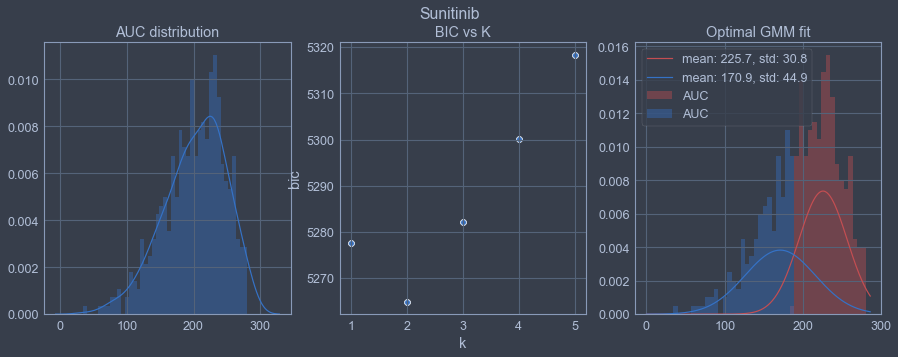

------------------------------------------------
Inhibitor:  Trametinib (GSK1120212)
------------------------------------------------
Number of assays (aucs): 454
Optimal K: 2 [BIC=5063.9]
GMM fit:
	Mixture Weights: array([0.53637806, 0.46362194])
	Means: array([ 86.55306617, 184.25571516])
	Variances: array([1299.10847577, 2471.94396084])
Class counts: ['class 0: 251', 'class 1: 203']


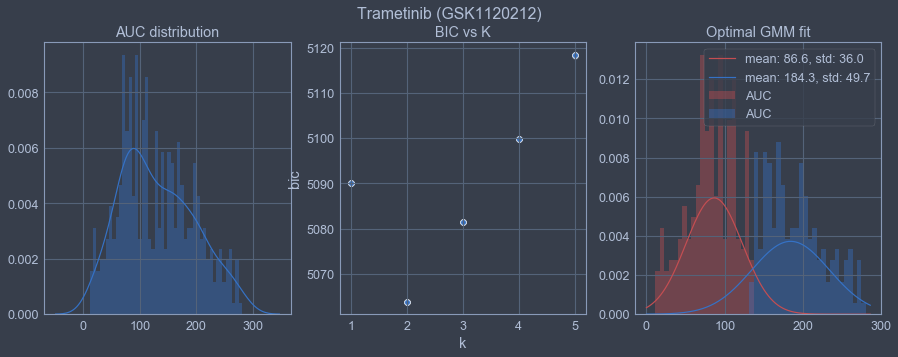

------------------------------------------------
Inhibitor:  Vandetanib (ZD6474)
------------------------------------------------
Number of assays (aucs): 491
Optimal K: 5 [BIC=5054.9]
GMM fit:
	Mixture Weights: array([0.17180258, 0.24301701, 0.23797422, 0.01875659, 0.3284496 ])
	Means: array([182.28329535, 273.32670811, 214.98242589,  66.23613882,
       235.1056218 ])
	Variances: array([1065.76813269,  110.94068831,  825.85574904, 1185.17304659,
        291.2411291 ])
Class counts: ['class 0: 72', 'class 1: 131', 'class 2: 67', 'class 3: 9', 'class 4: 212']


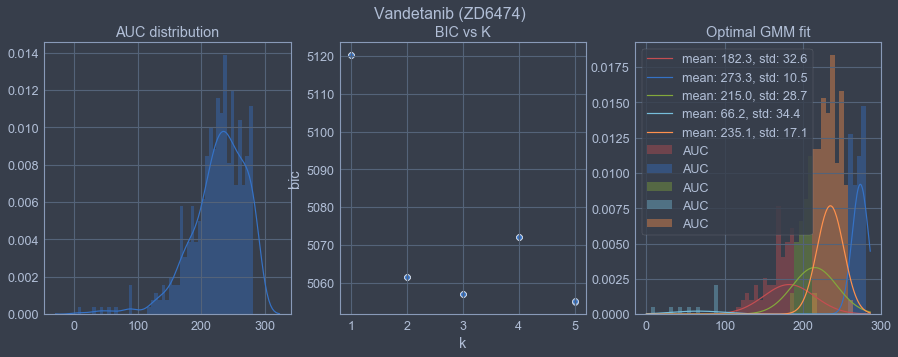

In [13]:
for inhib in aml_aucs.inhibitor.unique(): 
    inhib_dat = aml_aucs[aml_aucs.inhibitor == inhib]
    if inhib_dat.shape[0] > 450: 
        print('------------------------------------------------')
        print('Inhibitor:  %s' %inhib)
        print('------------------------------------------------')
        AUCS =  inhib_dat.auc.values.reshape(-1,1)
        test_multimodal_fits(AUCS, ntests=10, kmax=6, inhib=inhib, plot=True)
    

# Save subset of okay'd data

In [10]:
okay_data = ['YM-155', 'Vandetanib (ZD6474)', 'Trametinib (GSK1120212)', 'Sunitinib','Sorafenib', 'Selumetinib (AZD6244)', 'Nilotinib', 'JAK Inhibitor I', 'Pazopanib (GW786034)', 'Elesclomol', 'Dasatinib']

dat = aml_aucs[aml_aucs.inhibitor.isin(okay_data)]
dat.to_csv('./../data/beatAML_AUCs_subset.csv')

# Test HNSCC distribution

The next step is to ask, can we model these drug responses across cancer types? As in, are the distributions that are well defined by the beatAML similarly define the HNSCC distribution? 

We will try to test this by setting our null hypothesis as: 

Let X be the underlying set distribution such that: 
$$ AUC_{beatAML} \in X $$  

$$ H_0: AUC_{HNSCC} \in X $$ 
and 
$$ H_1: AUC_{HNSCC} \notin X $$ 

We will use permutation testing, and reject cases where `alpha=0.05`. 


In [14]:
HNSCC_all = pd.read_csv('./../beatAML_data/HNSCC_all_functional_data.csv')
HNSCC_auc = HNSCC_all[['lab_id','inhibitor','auc','call']].drop_duplicates()
HNSCC_auc.head()

lab_id            inhibitor       auc  call
0   10004           JQ1;BEZ235  1.044426   int
1   10004            Lucitanib  2.809226   res
2   10004          Resveratrol  2.794546   int
3   10004  Pelitinib (EKB-569)  1.221167  sens
4   10004         Bicalutamide  2.742498   int

In [15]:
shared_drugs = list( set(HNSCC_all.inhibitor) & set(aml_aucs.inhibitor) )

shared_drugs

['Neratinib (HKI-272)',
 'BI-2536',
 'Erlotinib',
 'JQ1',
 'YM-155',
 'Elesclomol',
 'GDC-0941',
 'BEZ235',
 'Taselisib (GDC-0032)',
 'Canertinib (CI-1033)',
 'Lestaurtinib (CEP-701)',
 'Tozasertib (VX-680)',
 'Pelitinib (EKB-569)',
 'PI-103',
 'PP242',
 'Nilotinib',
 'JNJ-28312141',
 'MK-2206',
 'Rapamycin',
 'Lenalidomide',
 '17-AAG (Tanespimycin)',
 'Selumetinib (AZD6244)',
 'STO609',
 'Selinexor',
 'MGCD-265',
 'SCH-772984',
 'Gefitinib',
 'Entrectinib',
 'Bortezomib (Velcade)',
 'A-674563',
 'GSK-1838705A',
 'MLN120B',
 'Panobinostat',
 'Flavopiridol',
 'Imatinib',
 'NVP-ADW742',
 'Sorafenib',
 'Lenvatinib',
 'INK-128',
 'TAK-659',
 'Lapatinib']

In [19]:
def permutation_test(x, y, n=1e5, verbose=True, return_prob=True, alpha=0.05):
    '''
    two tailed permutation test to see if y is apart of same model as x 
    
    returns the probability that y is not drawn from the same underlying model (or True if prob > 0.05 and return_prob=True)
    
    if pval > alpha -> x,y may not have been drawn from same distribution (alpha probability not drawn)
    
    H0: Distributions are the same 
    H1: the distributions are the not the same
    
    but we want 95% confidence that the distributions are the same... so, 
    '''
    x = x.ravel()
    y = y.ravel()
    z = np.append(x,y)
    
    T = np.abs( np.mean(x) - np.mean(y) )
    permutation_means = []

    for i in range(int(n)):
        if (i % 333 == 0) and verbose: print('Running permutations...[%.2f%%]' %(i/n*100), end='\r')
        perms = np.random.permutation(z)
        perm_y = perms[:len(y)]
        perm_x = perms[len(y):]
        permutation_means.append( np.abs(np.mean(perm_y) - np.mean(perm_x)) )
    print()
    
    print(np.sum(1* np.array(permutation_means) > T))

    pval = np.sum( 1*np.array(permutation_means) > T ) / len( permutation_means )
    return pval if return_prob else pval >= alpha

def test_distribution_similarity(aml, hnscc, inhib=None, verbose=True, perms=1e5): 
    '''
    
    '''
    if verbose: print('---------------------------------------------------------')
    if verbose: print('XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX')
    if verbose: print(inhib)
    if verbose: print('XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX')
    if verbose: print('---------------------------------------------------------')
    if verbose: print()
        
    print('HNSCC assays:    %d' %hnscc.shape[0])
    print('AML assays:      %d' %aml.shape[0])
        
    test_multimodal_fits(aml, ntests=10, kmax=6, inhib=inhib, plot=True)
    test_multimodal_fits(hnscc, ntests=10, kmax=6, inhib=inhib, plot=True)
    test_multimodal_fits(np.append(aml.ravel(),hnscc.ravel()).reshape(-1,1), ntests=10, kmax=6, inhib=inhib + ' hnscc-aml', plot=True)
    
    nbins=50
    bin_ = np.arange(0,300,300/nbins)

    plt.figure()
    plt.hist(aml_,color='blue',label='AML_AUC',normed=True,alpha=0.4,bins=bin_)
    plt.hist(hnscc_,color='red',label='HNSCC_AUC',normed=True,alpha=0.4,bins=bin_)
    plt.legend()
    plt.show()
    
    pval = permutation_test(aml_, hnscc_, n=perms, verbose=True, return_prob=True)
    if verbose: print('Dasatinib permutation test p-value: %f' %pval)
    

---------------------------------------------------------
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Neratinib (HKI-272)
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
---------------------------------------------------------

HNSCC assays:    17
AML assays:      433
Number of assays (aucs): 433
Optimal K: 1 [BIC=4559.0]
GMM fit:
	Mixture Weights: array([1.])
	Means: array([161.97390563])
	Variances: array([2127.98147262])
Class counts: ['class 0: 433']


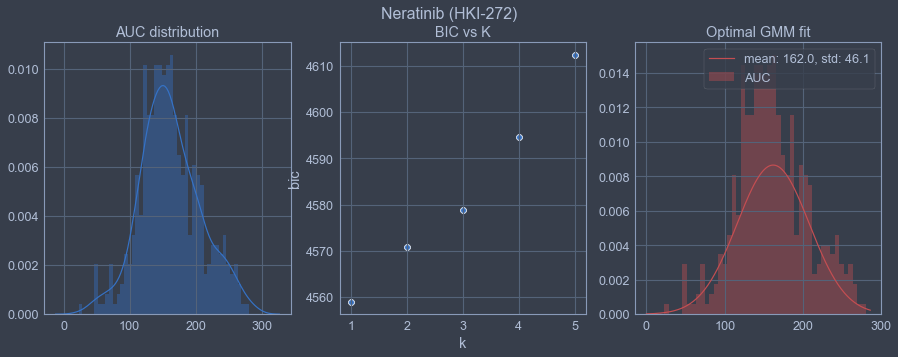

Number of assays (aucs): 17
Optimal K: 1 [BIC=181.7]
GMM fit:
	Mixture Weights: array([1.])
	Means: array([198.79088486])
	Variances: array([1841.24814213])
Class counts: ['class 0: 17']


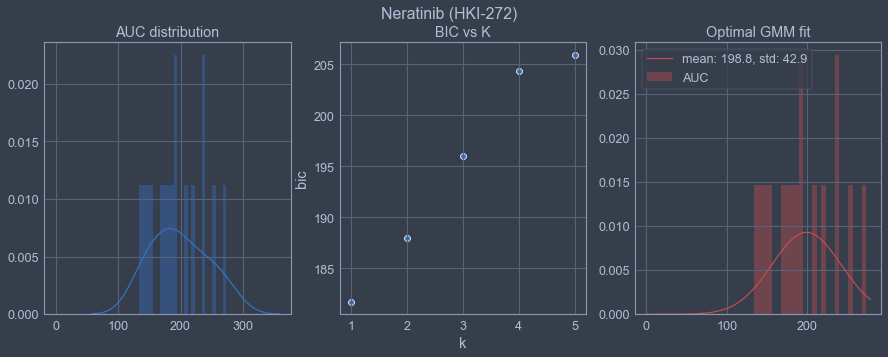

Number of assays (aucs): 450
Optimal K: 1 [BIC=4745.6]
GMM fit:
	Mixture Weights: array([1.])
	Means: array([163.36476929])
	Variances: array([2166.42222135])
Class counts: ['class 0: 450']


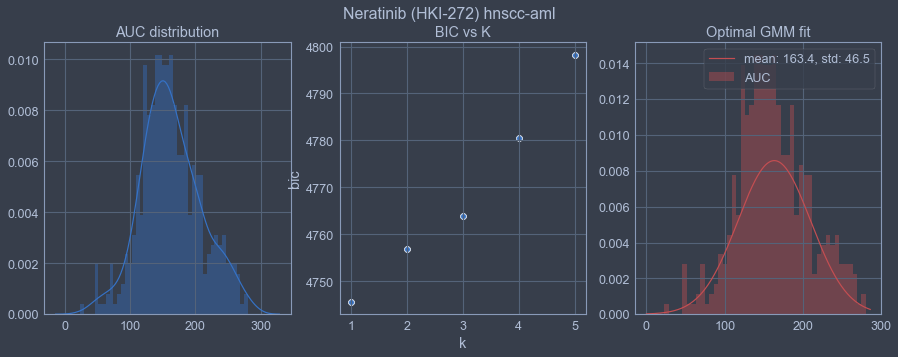

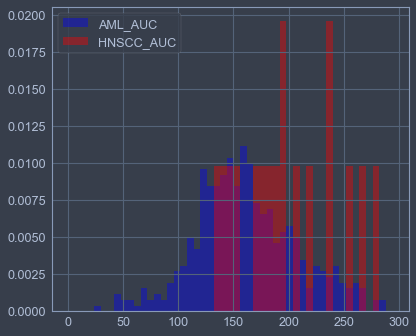

Running permutations...[99.90%]
137
Dasatinib permutation test p-value: 0.001370
---------------------------------------------------------
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Erlotinib
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
---------------------------------------------------------

HNSCC assays:    16
AML assays:      494
Number of assays (aucs): 494
Optimal K: 2 [BIC=4859.8]
GMM fit:
	Mixture Weights: array([0.38335743, 0.61664257])
	Means: array([206.5011893 , 245.32512682])
	Variances: array([1367.04298121,  453.23643433])
Class counts: ['class 0: 136', 'class 1: 358']


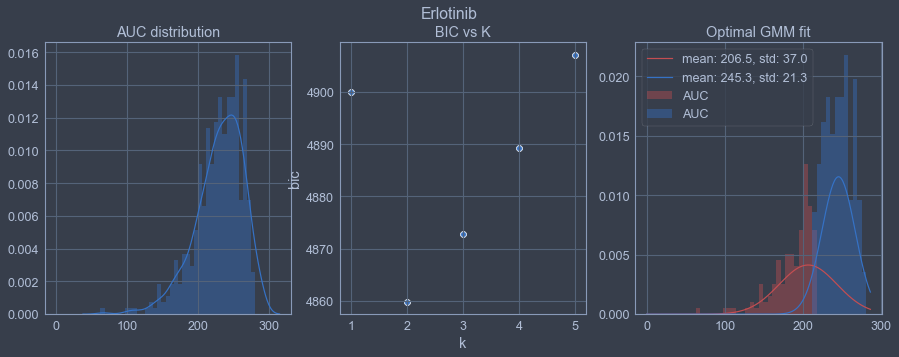

Number of assays (aucs): 16
Optimal K: 2 [BIC=167.2]
GMM fit:
	Mixture Weights: array([0.56753554, 0.43246446])
	Means: array([250.87091923, 174.57280577])
	Variances: array([504.39099167,  80.49344992])
Class counts: ['class 0: 9', 'class 1: 7']


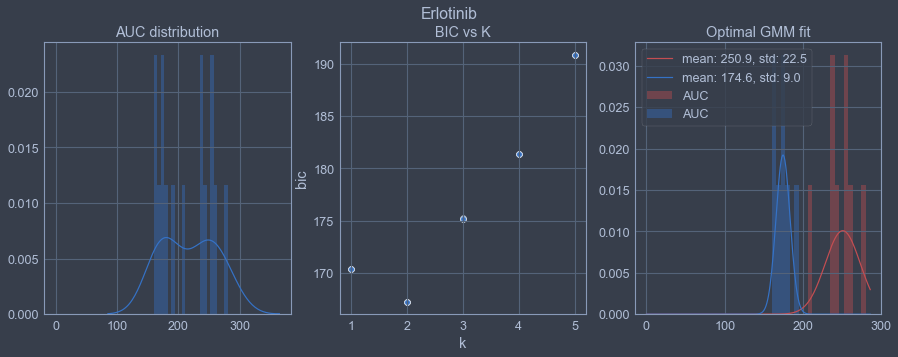

Number of assays (aucs): 510
Optimal K: 2 [BIC=5027.4]
GMM fit:
	Mixture Weights: array([0.61394137, 0.38605863])
	Means: array([245.55550283, 205.38523382])
	Variances: array([ 456.70019842, 1347.79182011])
Class counts: ['class 0: 366', 'class 1: 144']


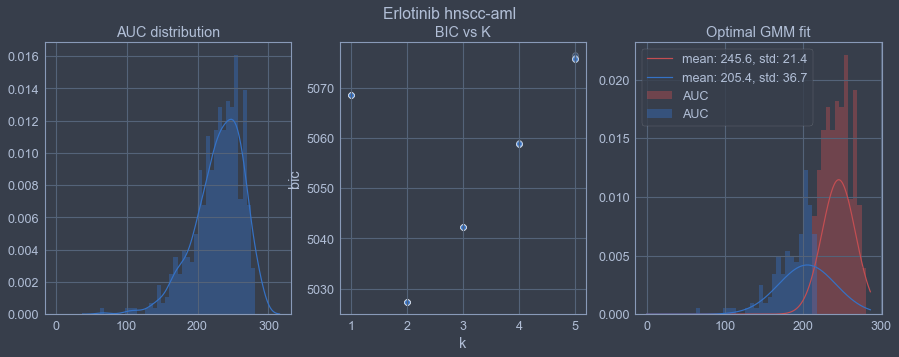

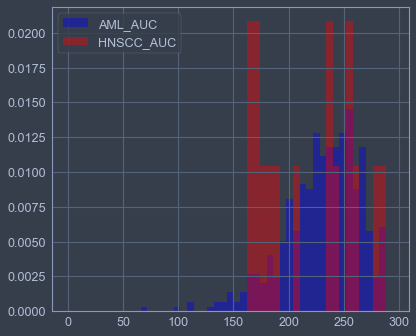

Running permutations...[99.90%]
14987
Dasatinib permutation test p-value: 0.149870
---------------------------------------------------------
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
JQ1
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
---------------------------------------------------------

HNSCC assays:    16
AML assays:      287
Number of assays (aucs): 287
Optimal K: 1 [BIC=2998.5]
GMM fit:
	Mixture Weights: array([1.])
	Means: array([138.15140233])
	Variances: array([1940.26046556])
Class counts: ['class 0: 287']


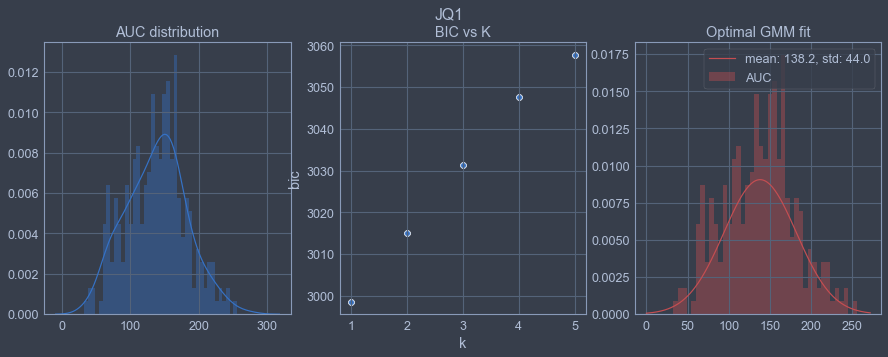

Number of assays (aucs): 16
Optimal K: 1 [BIC=157.1]
GMM fit:
	Mixture Weights: array([1.])
	Means: array([254.57338597])
	Variances: array([761.13249173])
Class counts: ['class 0: 16']


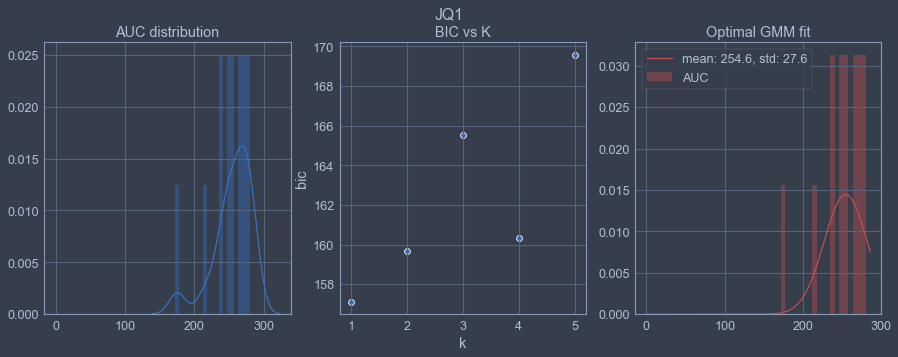

Number of assays (aucs): 303
Optimal K: 1 [BIC=3248.7]
GMM fit:
	Mixture Weights: array([1.])
	Means: array([144.29909784])
	Variances: array([2555.92902767])
Class counts: ['class 0: 303']


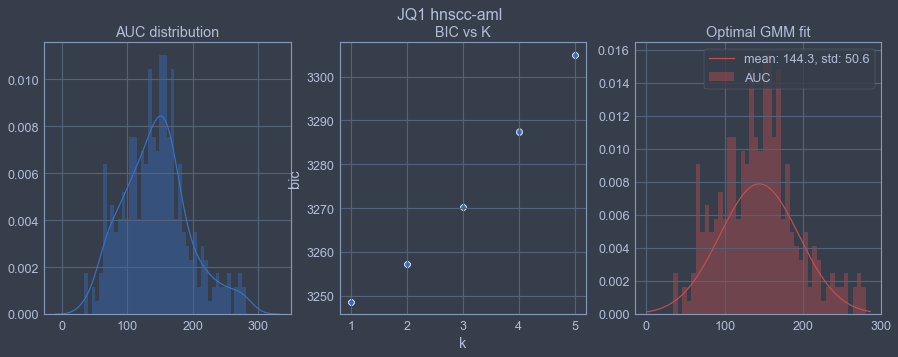

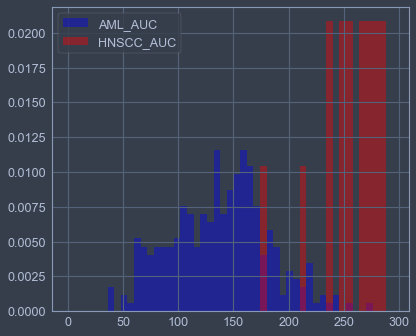

Running permutations...[99.90%]
0
Dasatinib permutation test p-value: 0.000000
---------------------------------------------------------
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
YM-155
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
---------------------------------------------------------

HNSCC assays:    17
AML assays:      438
Number of assays (aucs): 438
Optimal K: 4 [BIC=4293.3]
GMM fit:
	Mixture Weights: array([0.41133395, 0.29782339, 0.24887023, 0.04197242])
	Means: array([248.08561307, 212.2240844 , 279.42325154, 175.08078398])
	Variances: array([ 287.4991658 ,  717.58205777,   36.56865149, 2604.53227968])
Class counts: ['class 0: 195', 'class 1: 117', 'class 2: 120', 'class 3: 6']


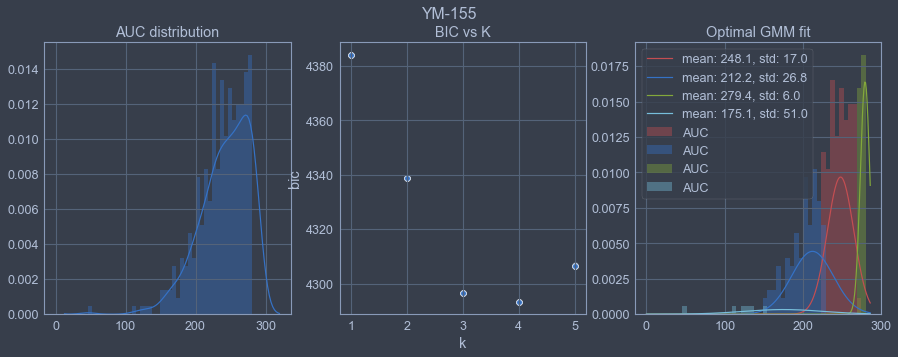

Number of assays (aucs): 17
Optimal K: 4 [BIC=147.8]
GMM fit:
	Mixture Weights: array([0.11953286, 0.05882353, 0.64517302, 0.17647059])
	Means: array([ 32.12945874, 110.62030442,   5.64480744,  96.79862275])
	Variances: array([5.21418920e+01, 1.00000003e-03, 1.72868280e+01, 2.70989575e+00])
Class counts: ['class 0: 2', 'class 1: 1', 'class 2: 11', 'class 3: 3']


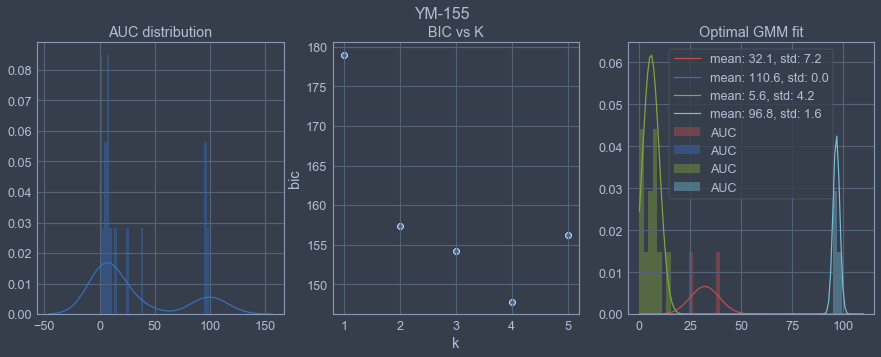

Number of assays (aucs): 455
Optimal K: 5 [BIC=4584.5]
GMM fit:
	Mixture Weights: array([0.06199996, 0.21226811, 0.02372275, 0.3802712 , 0.32173798])
	Means: array([152.79858637, 280.5128593 ,   5.62276955, 251.89175561,
       215.44222246])
	Variances: array([3796.64448077,   26.65361388,   17.12954887,  257.44100819,
        629.90058102])
Class counts: ['class 0: 15', 'class 1: 109', 'class 2: 11', 'class 3: 181', 'class 4: 139']


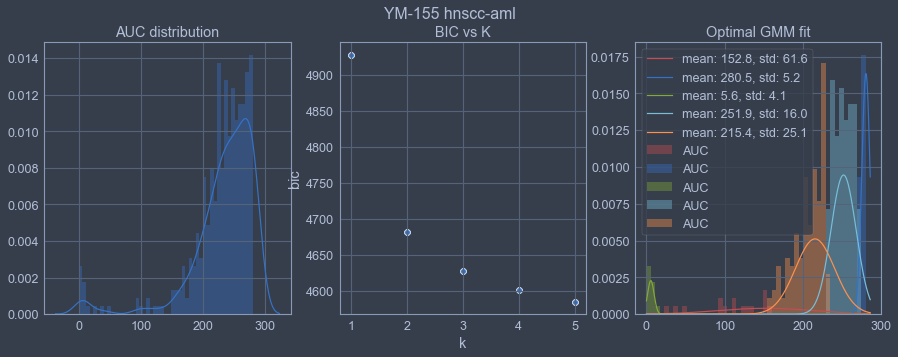

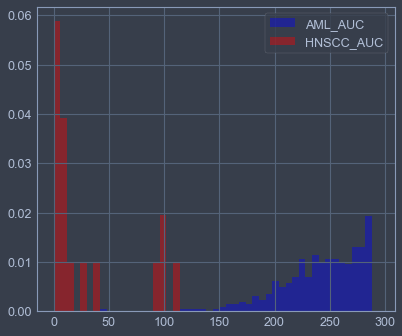

Running permutations...[99.90%]
0
Dasatinib permutation test p-value: 0.000000
---------------------------------------------------------
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Elesclomol
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
---------------------------------------------------------

HNSCC assays:    17
AML assays:      401
Number of assays (aucs): 401
Optimal K: 3 [BIC=4037.7]
GMM fit:
	Mixture Weights: array([0.51174539, 0.09239963, 0.39585498])
	Means: array([ 26.350298  , 203.44968902,  66.66850544])
	Variances: array([ 166.22601469, 2510.66009017,  612.43965939])
Class counts: ['class 0: 221', 'class 1: 36', 'class 2: 144']


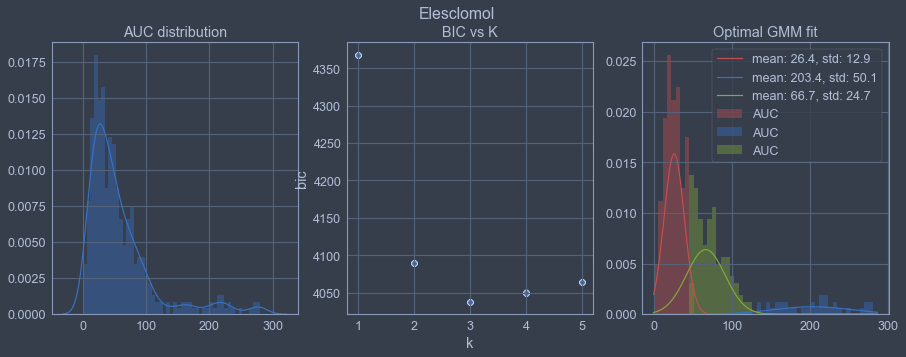

Number of assays (aucs): 17
Optimal K: 1 [BIC=193.6]
GMM fit:
	Mixture Weights: array([1.])
	Means: array([169.47474365])
	Variances: array([3705.46371316])
Class counts: ['class 0: 17']


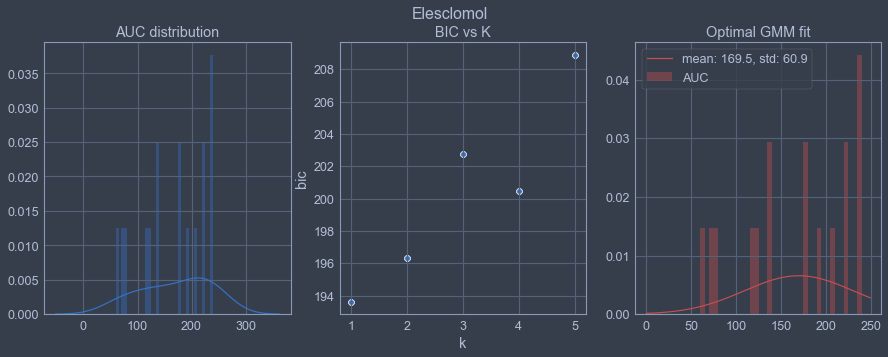

Number of assays (aucs): 418
Optimal K: 3 [BIC=4273.2]
GMM fit:
	Mixture Weights: array([0.49921366, 0.11525207, 0.38553427])
	Means: array([ 26.79928211, 204.38562685,  68.07742676])
	Variances: array([ 174.53977652, 2174.40540799,  663.55369744])
Class counts: ['class 0: 223', 'class 1: 48', 'class 2: 147']


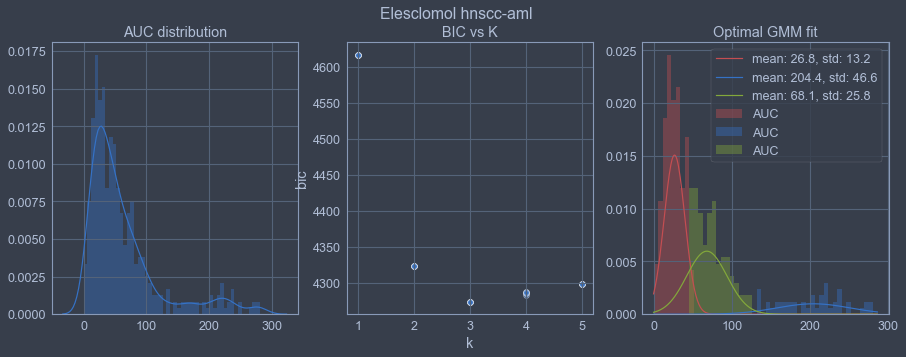

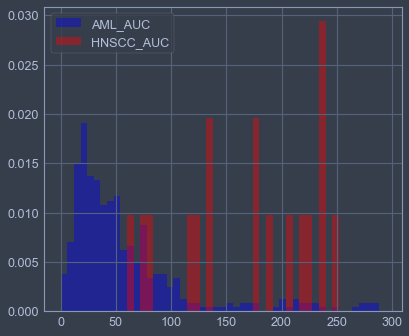

Running permutations...[99.90%]
0
Dasatinib permutation test p-value: 0.000000
---------------------------------------------------------
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
GDC-0941
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
---------------------------------------------------------

HNSCC assays:    17
AML assays:      403
Number of assays (aucs): 403
Optimal K: 1 [BIC=4211.5]
GMM fit:
	Mixture Weights: array([1.])
	Means: array([155.88303782])
	Variances: array([1964.208886])
Class counts: ['class 0: 403']


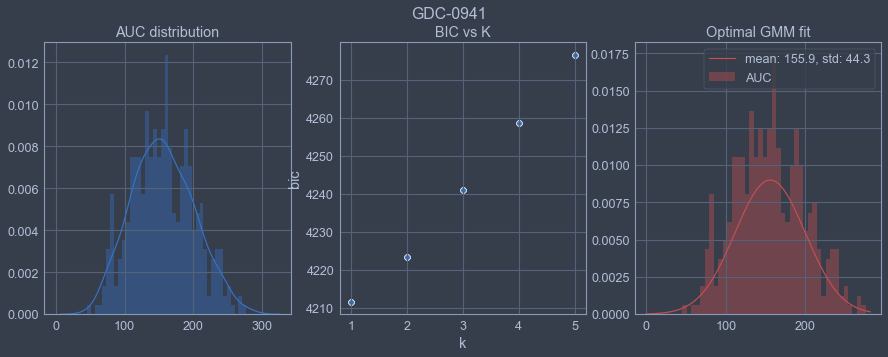

Number of assays (aucs): 17
Optimal K: 1 [BIC=178.4]
GMM fit:
	Mixture Weights: array([1.])
	Means: array([132.14193862])
	Variances: array([1515.04185105])
Class counts: ['class 0: 17']


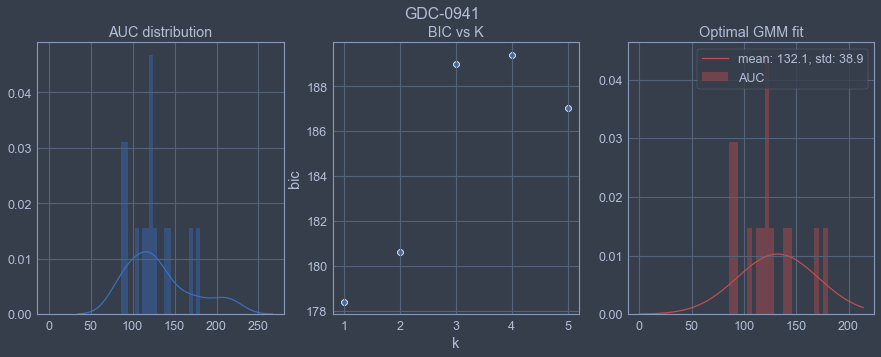

Number of assays (aucs): 420
Optimal K: 1 [BIC=4389.6]
GMM fit:
	Mixture Weights: array([1.])
	Means: array([154.92208856])
	Variances: array([1967.91888361])
Class counts: ['class 0: 420']


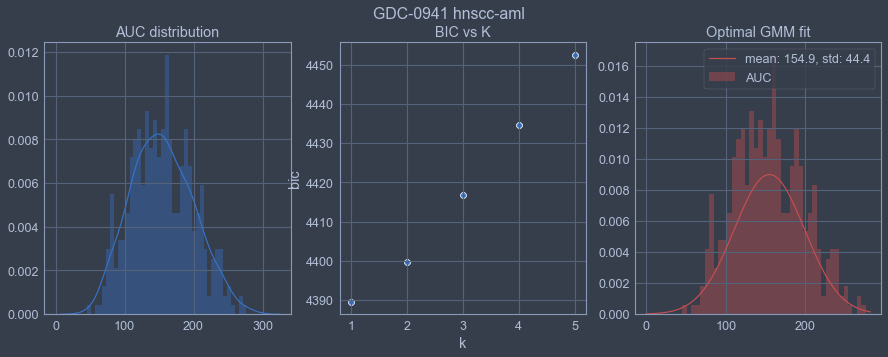

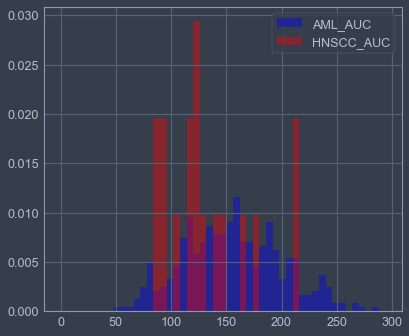

Running permutations...[99.90%]
3060
Dasatinib permutation test p-value: 0.030600
---------------------------------------------------------
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
BEZ235
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
---------------------------------------------------------

HNSCC assays:    17
AML assays:      423
Number of assays (aucs): 423
Optimal K: 1 [BIC=4549.3]
GMM fit:
	Mixture Weights: array([1.])
	Means: array([155.1396563])
	Variances: array([2665.87541679])
Class counts: ['class 0: 423']


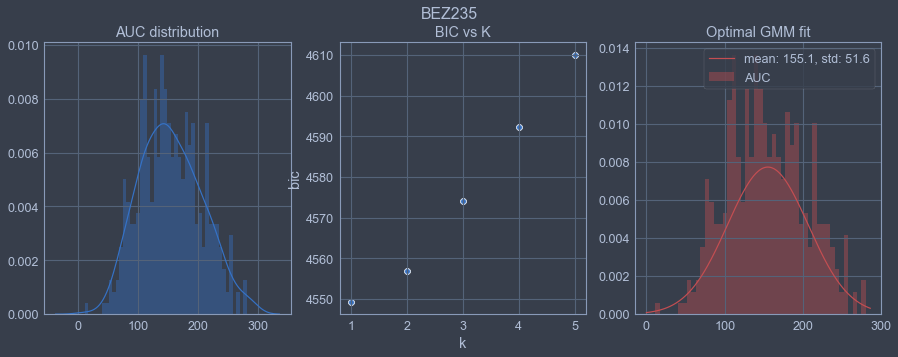

Number of assays (aucs): 17
Optimal K: 1 [BIC=179.9]
GMM fit:
	Mixture Weights: array([1.])
	Means: array([126.14004924])
	Variances: array([1652.66669288])
Class counts: ['class 0: 17']


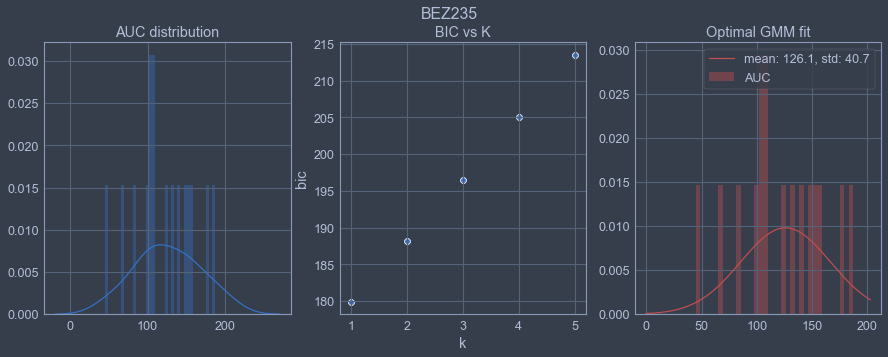

Number of assays (aucs): 440
Optimal K: 1 [BIC=4730.4]
GMM fit:
	Mixture Weights: array([1.])
	Means: array([154.01921693])
	Variances: array([2657.965633])
Class counts: ['class 0: 440']


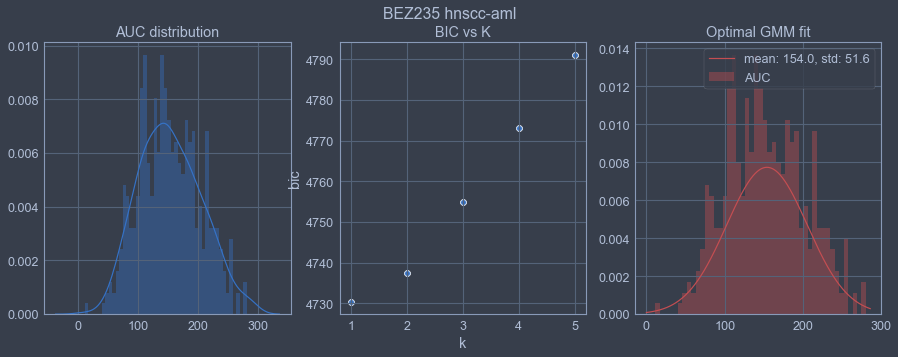

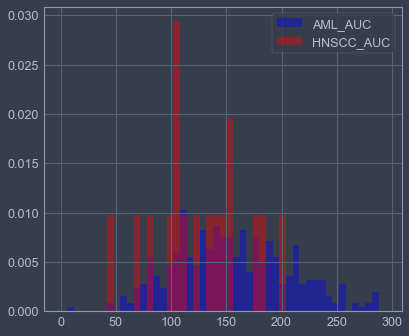

Running permutations...[99.90%]
2247
Dasatinib permutation test p-value: 0.022470
---------------------------------------------------------
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Canertinib (CI-1033)
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
---------------------------------------------------------

HNSCC assays:    17
AML assays:      432
Number of assays (aucs): 432
Optimal K: 2 [BIC=4345.4]
GMM fit:
	Mixture Weights: array([0.31247043, 0.68752957])
	Means: array([195.47543171, 231.11659019])
	Variances: array([2461.64893922,  638.25502618])
Class counts: ['class 0: 69', 'class 1: 363']


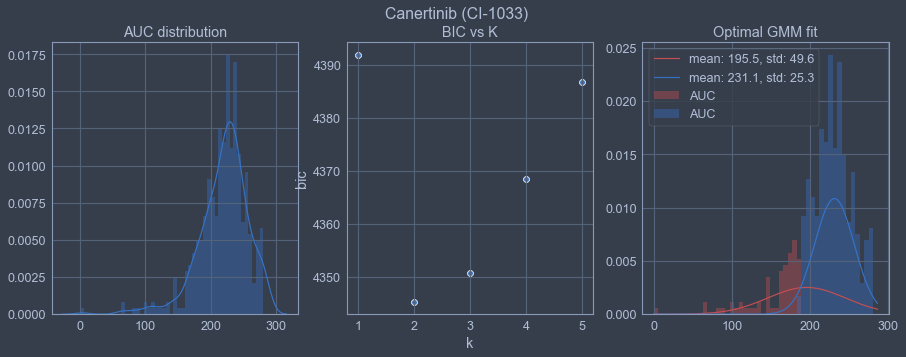

Number of assays (aucs): 17
Optimal K: 1 [BIC=185.1]
GMM fit:
	Mixture Weights: array([1.])
	Means: array([200.46679617])
	Variances: array([2247.4254111])
Class counts: ['class 0: 17']


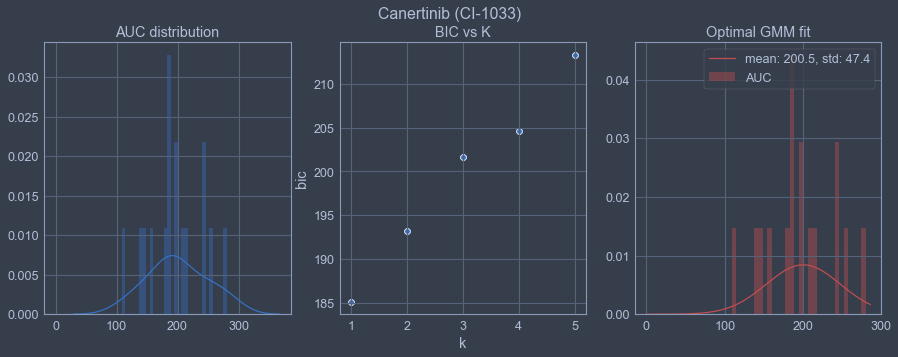

Number of assays (aucs): 449
Optimal K: 2 [BIC=4534.1]
GMM fit:
	Mixture Weights: array([0.66382662, 0.33617338])
	Means: array([231.47388764, 195.08521019])
	Variances: array([ 650.49622461, 2369.28933194])
Class counts: ['class 0: 368', 'class 1: 81']


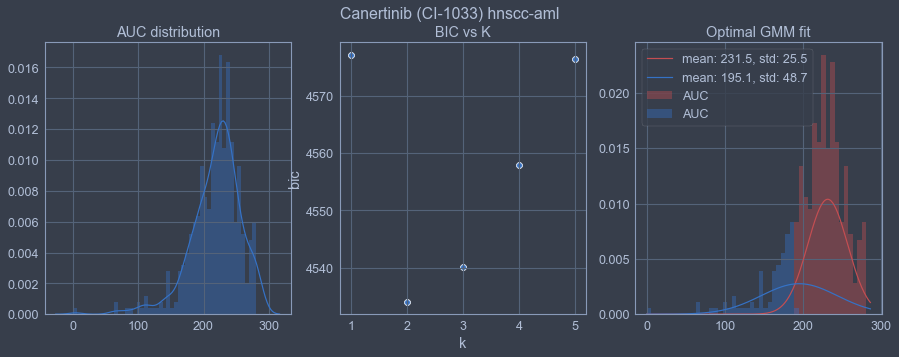

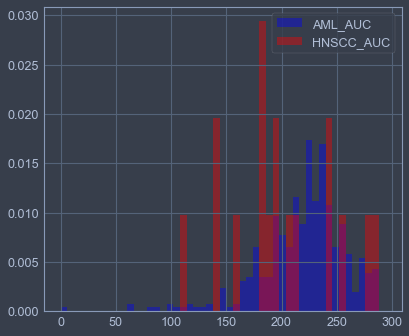

Running permutations...[99.90%]
4388
Dasatinib permutation test p-value: 0.043880
---------------------------------------------------------
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Tozasertib (VX-680)
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
---------------------------------------------------------

HNSCC assays:    17
AML assays:      436
Number of assays (aucs): 436
Optimal K: 2 [BIC=4440.2]
GMM fit:
	Mixture Weights: array([0.66291631, 0.33708369])
	Means: array([227.08966462, 184.24468239])
	Variances: array([ 718.34101867, 2144.77726346])
Class counts: ['class 0: 352', 'class 1: 84']


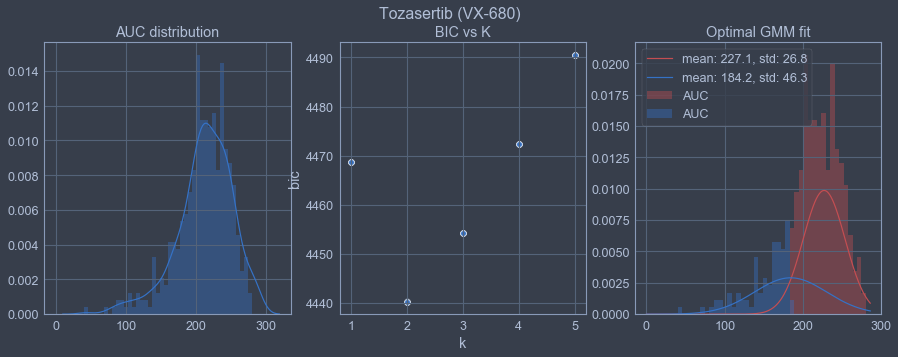

Number of assays (aucs): 17
Optimal K: 1 [BIC=167.2]
GMM fit:
	Mixture Weights: array([1.])
	Means: array([236.30828056])
	Variances: array([783.72554039])
Class counts: ['class 0: 17']


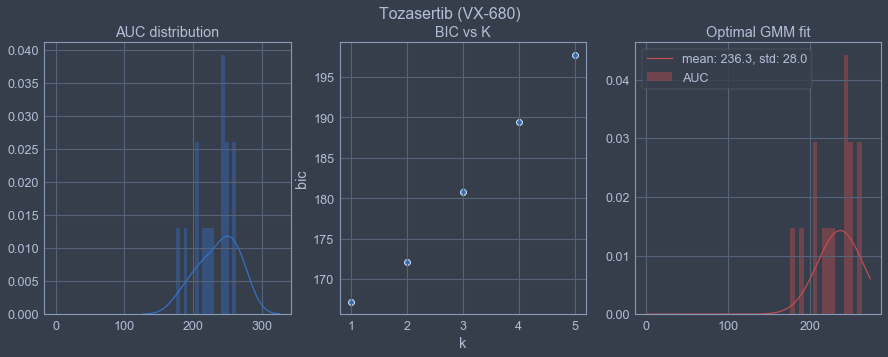

Number of assays (aucs): 453
Optimal K: 2 [BIC=4609.7]
GMM fit:
	Mixture Weights: array([0.66176668, 0.33823332])
	Means: array([227.95382197, 185.32477745])
	Variances: array([ 717.04548478, 2120.82972573])
Class counts: ['class 0: 364', 'class 1: 89']


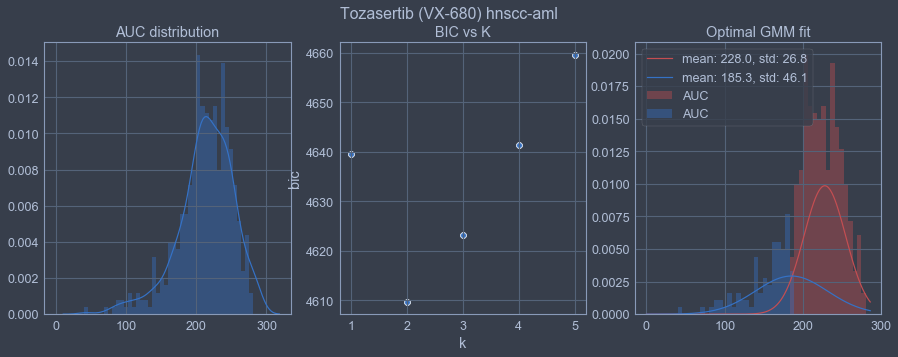

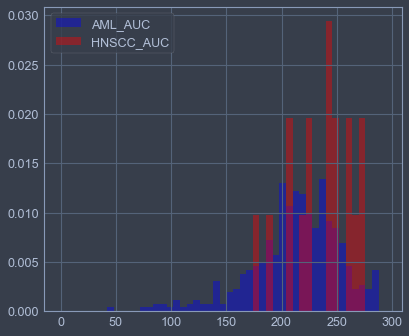

Running permutations...[99.90%]
1748
Dasatinib permutation test p-value: 0.017480
---------------------------------------------------------
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Pelitinib (EKB-569)
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
---------------------------------------------------------

HNSCC assays:    17
AML assays:      431
Number of assays (aucs): 431
Optimal K: 1 [BIC=4461.9]
GMM fit:
	Mixture Weights: array([1.])
	Means: array([163.13544434])
	Variances: array([1783.6839003])
Class counts: ['class 0: 431']


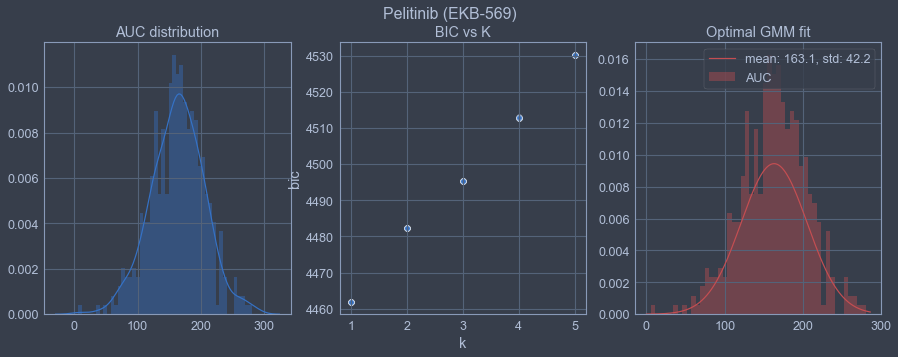

Number of assays (aucs): 17
Optimal K: 3 [BIC=190.9]
GMM fit:
	Mixture Weights: array([0.17555746, 0.41183301, 0.41260953])
	Means: array([184.53144187, 254.52541837, 132.79205761])
	Variances: array([  4.68212506, 330.0789751 , 287.93931569])
Class counts: ['class 0: 3', 'class 1: 7', 'class 2: 7']


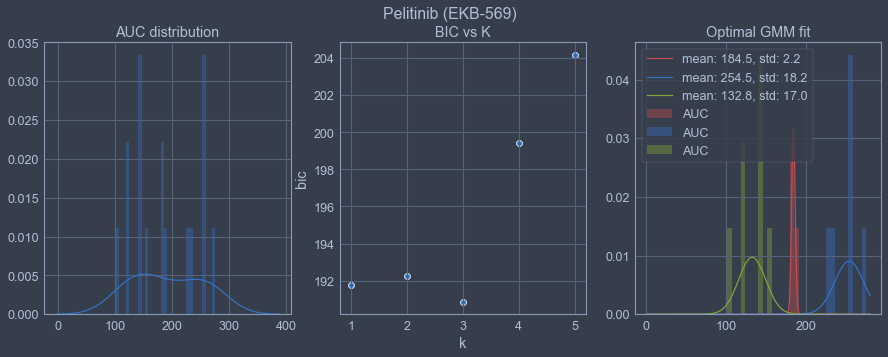

Number of assays (aucs): 448
Optimal K: 1 [BIC=4659.3]
GMM fit:
	Mixture Weights: array([1.])
	Means: array([164.2310968])
	Variances: array([1872.48593435])
Class counts: ['class 0: 448']


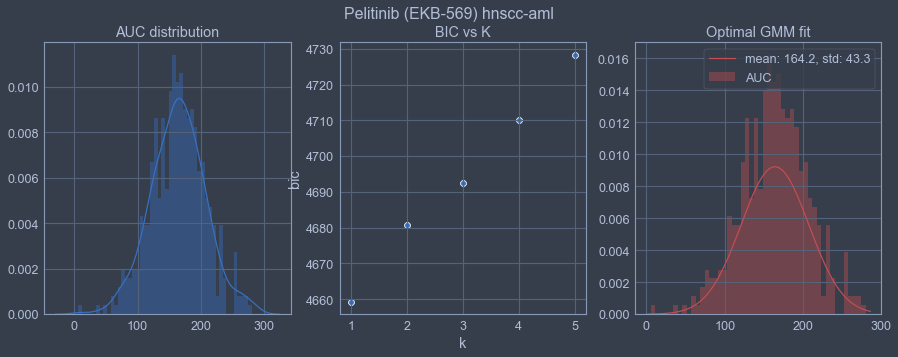

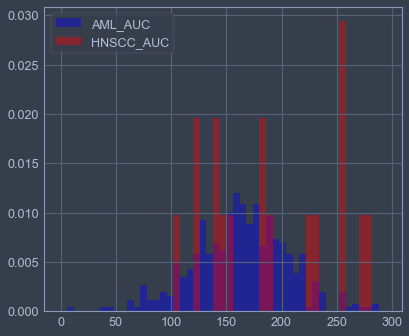

Running permutations...[99.90%]
751
Dasatinib permutation test p-value: 0.007510
---------------------------------------------------------
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
PI-103
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
---------------------------------------------------------

HNSCC assays:    17
AML assays:      432
Number of assays (aucs): 432
Optimal K: 1 [BIC=4592.6]
GMM fit:
	Mixture Weights: array([1.])
	Means: array([140.35699877])
	Variances: array([2356.66433103])
Class counts: ['class 0: 432']


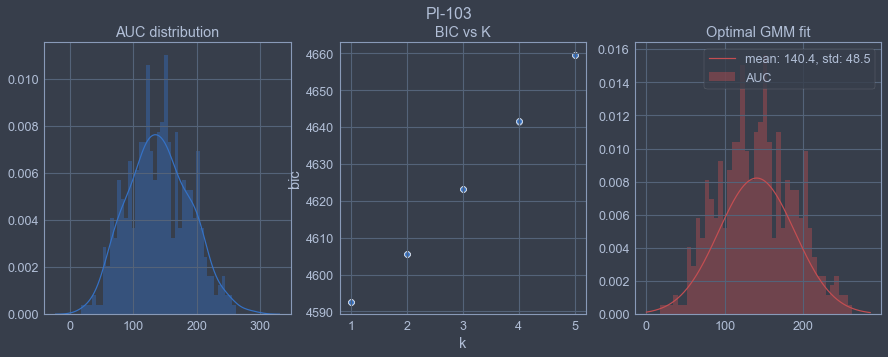

Number of assays (aucs): 17
Optimal K: 1 [BIC=178.0]
GMM fit:
	Mixture Weights: array([1.])
	Means: array([137.60132803])
	Variances: array([1479.84516686])
Class counts: ['class 0: 17']


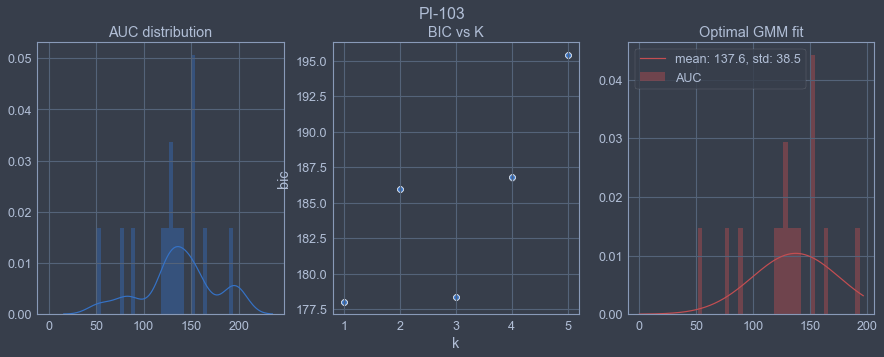

Number of assays (aucs): 449
Optimal K: 1 [BIC=4766.6]
GMM fit:
	Mixture Weights: array([1.])
	Means: array([140.2526638])
	Variances: array([2323.74290509])
Class counts: ['class 0: 449']


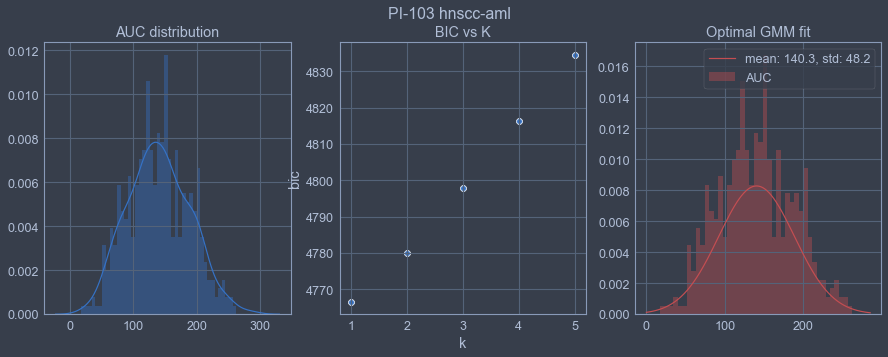

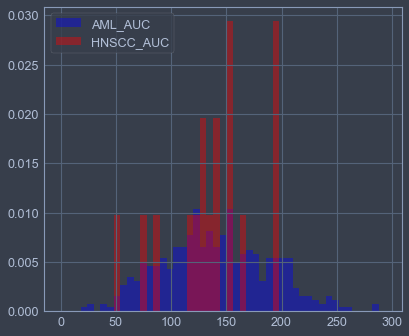

Running permutations...[99.90%]
81763
Dasatinib permutation test p-value: 0.817630
---------------------------------------------------------
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
PP242
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
---------------------------------------------------------

HNSCC assays:    17
AML assays:      432
Number of assays (aucs): 432
Optimal K: 1 [BIC=4575.4]
GMM fit:
	Mixture Weights: array([1.])
	Means: array([139.92493152])
	Variances: array([2264.95055139])
Class counts: ['class 0: 432']


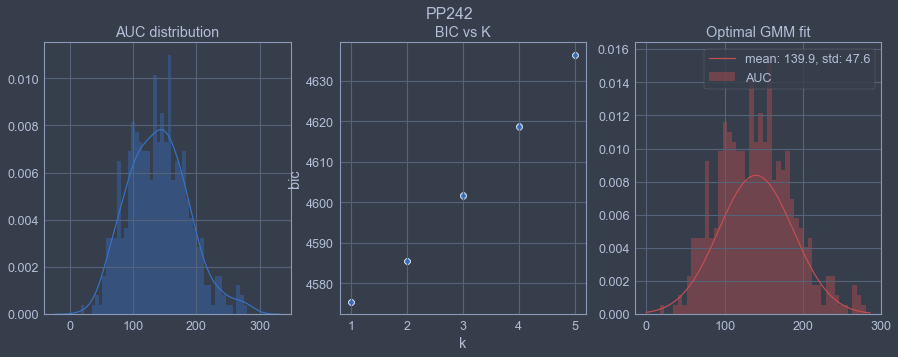

Number of assays (aucs): 17
Optimal K: 1 [BIC=175.0]
GMM fit:
	Mixture Weights: array([1.])
	Means: array([199.8533003])
	Variances: array([1241.56981283])
Class counts: ['class 0: 17']


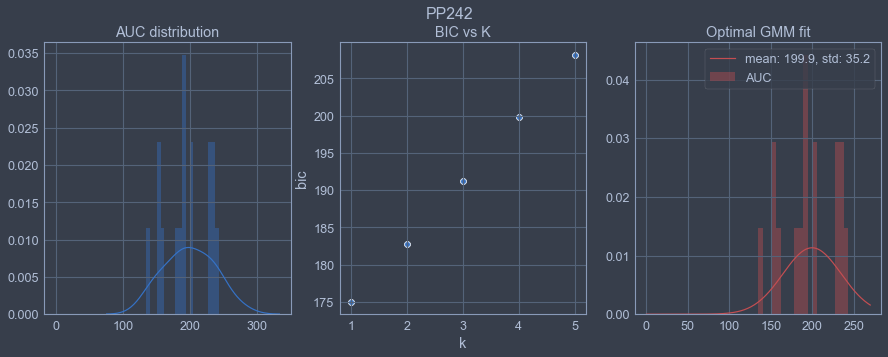

Number of assays (aucs): 449
Optimal K: 1 [BIC=4773.0]
GMM fit:
	Mixture Weights: array([1.])
	Means: array([142.19393434])
	Variances: array([2357.03266083])
Class counts: ['class 0: 449']


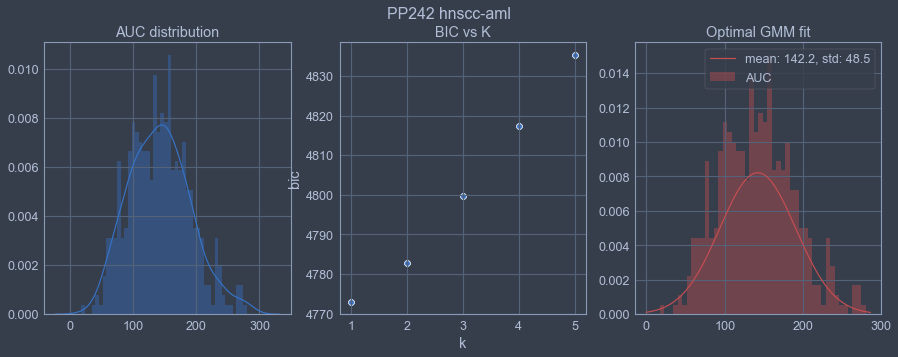

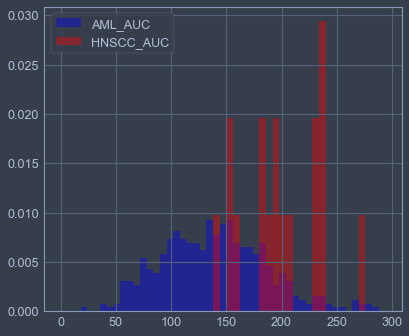

Running permutations...[99.90%]
0
Dasatinib permutation test p-value: 0.000000
---------------------------------------------------------
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Nilotinib
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
---------------------------------------------------------

HNSCC assays:    16
AML assays:      495
Number of assays (aucs): 495
Optimal K: 2 [BIC=5019.4]
GMM fit:
	Mixture Weights: array([0.50233536, 0.49766464])
	Means: array([199.7455403 , 255.40790252])
	Variances: array([1001.10418362,  462.24300534])
Class counts: ['class 0: 237', 'class 1: 258']


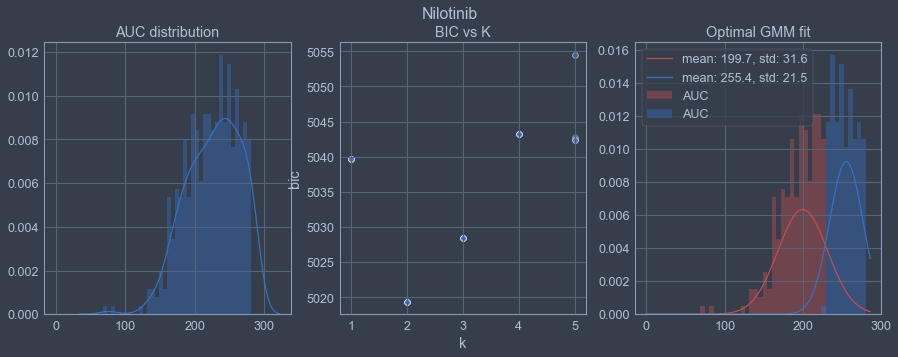

Number of assays (aucs): 16
Optimal K: 3 [BIC=136.6]
GMM fit:
	Mixture Weights: array([0.52113369, 0.0625    , 0.41636631])
	Means: array([279.71264701, 202.10509219, 258.40193221])
	Variances: array([1.44996077e+01, 1.00000009e-03, 1.06721442e+02])
Class counts: ['class 0: 9', 'class 1: 1', 'class 2: 6']


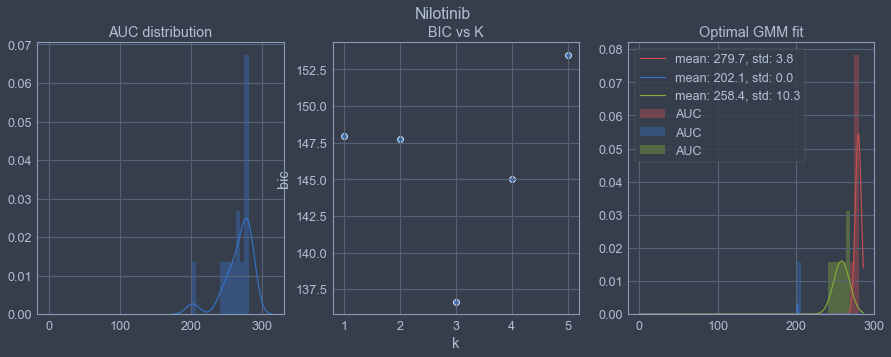

Number of assays (aucs): 511
Optimal K: 2 [BIC=5177.0]
GMM fit:
	Mixture Weights: array([0.49572025, 0.50427975])
	Means: array([257.28957676, 200.50355557])
	Variances: array([425.29868289, 995.182392  ])
Class counts: ['class 0: 269', 'class 1: 242']


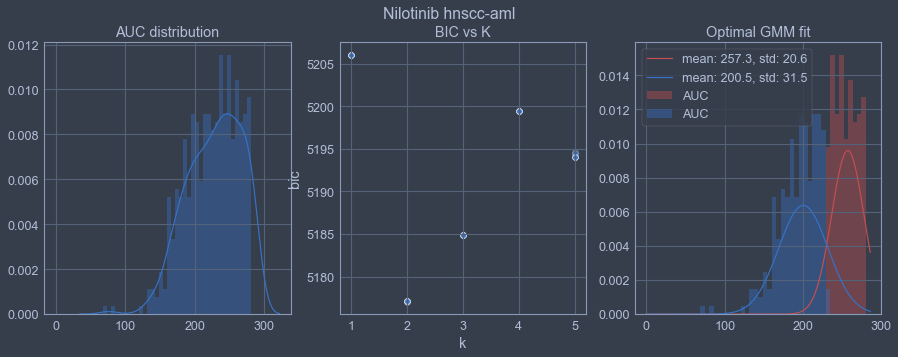

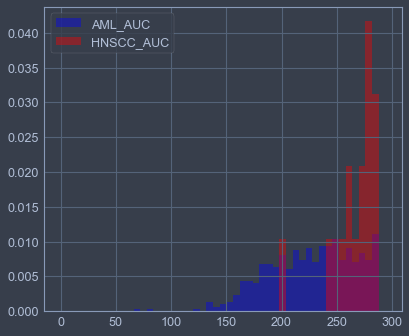

Running permutations...[99.90%]
15
Dasatinib permutation test p-value: 0.000150
---------------------------------------------------------
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
JNJ-28312141
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
---------------------------------------------------------

HNSCC assays:    17
AML assays:      419
Number of assays (aucs): 419
Optimal K: 1 [BIC=4639.4]
GMM fit:
	Mixture Weights: array([1.])
	Means: array([143.79579035])
	Variances: array([3661.97483019])
Class counts: ['class 0: 419']


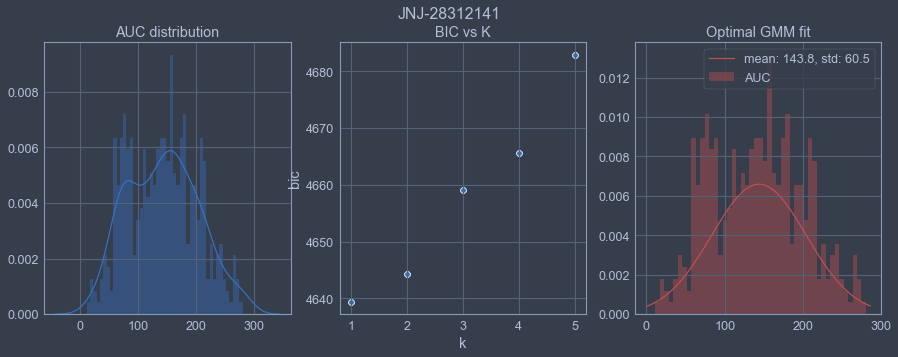

Number of assays (aucs): 17
Optimal K: 1 [BIC=149.3]
GMM fit:
	Mixture Weights: array([1.])
	Means: array([251.8606813])
	Variances: array([272.87665377])
Class counts: ['class 0: 17']


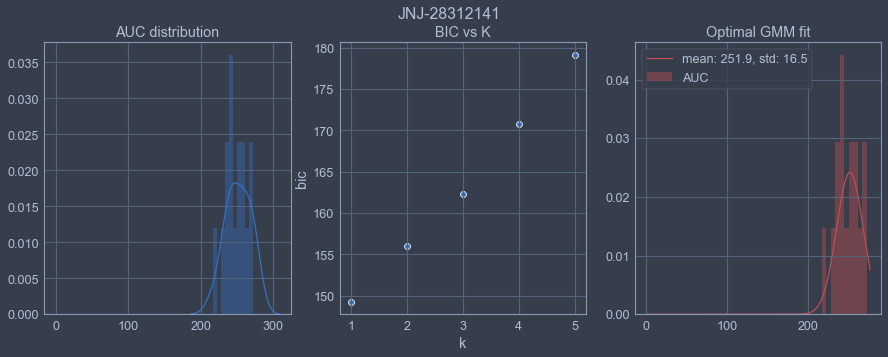

Number of assays (aucs): 436
Optimal K: 1 [BIC=4862.1]
GMM fit:
	Mixture Weights: array([1.])
	Means: array([148.00932968])
	Variances: array([3967.41284807])
Class counts: ['class 0: 436']


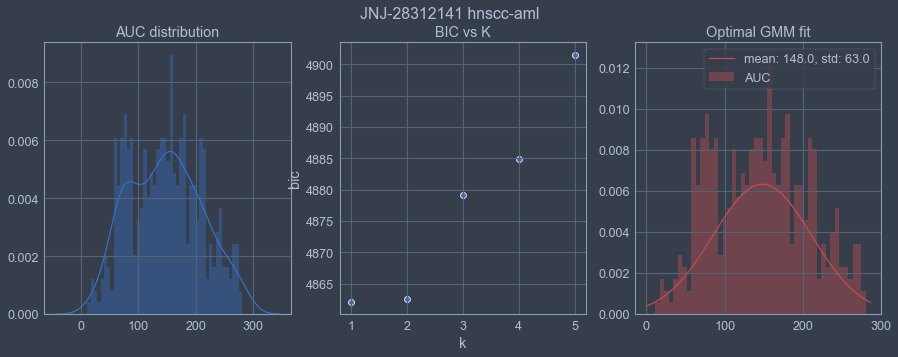

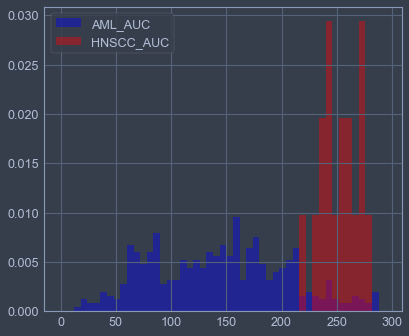

Running permutations...[99.90%]
0
Dasatinib permutation test p-value: 0.000000
---------------------------------------------------------
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
MK-2206
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
---------------------------------------------------------

HNSCC assays:    17
AML assays:      420
Number of assays (aucs): 420
Optimal K: 2 [BIC=4559.8]
GMM fit:
	Mixture Weights: array([0.50416044, 0.49583956])
	Means: array([245.37914994, 166.09399066])
	Variances: array([ 823.23414807, 2397.58311345])
Class counts: ['class 0: 228', 'class 1: 192']


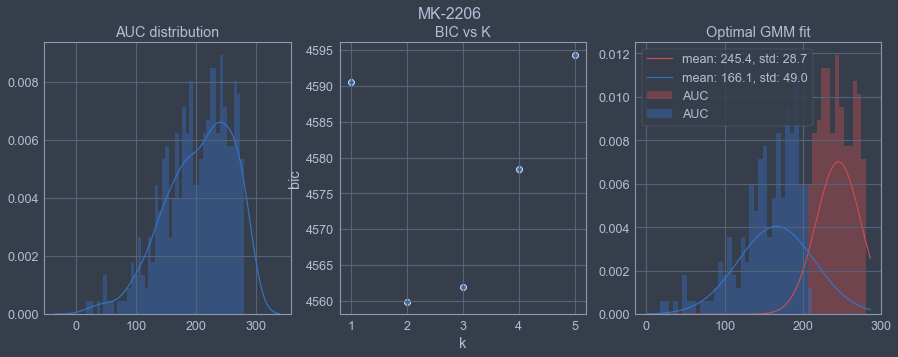

Number of assays (aucs): 17
Optimal K: 1 [BIC=168.0]
GMM fit:
	Mixture Weights: array([1.])
	Means: array([250.91065639])
	Variances: array([819.96981588])
Class counts: ['class 0: 17']


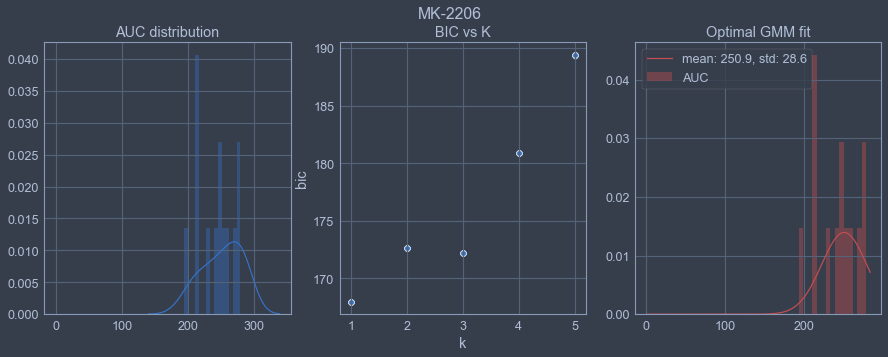

Number of assays (aucs): 437
Optimal K: 2 [BIC=4737.2]
GMM fit:
	Mixture Weights: array([0.51658519, 0.48341481])
	Means: array([246.05068468, 166.94731455])
	Variances: array([ 818.13812116, 2427.71585776])
Class counts: ['class 0: 244', 'class 1: 193']


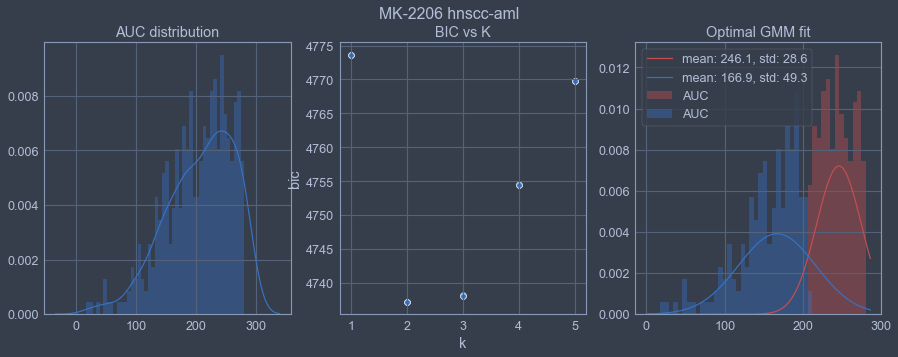

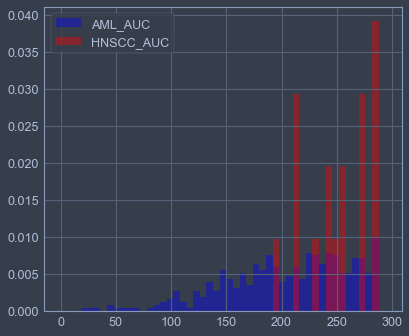

Running permutations...[99.90%]
116
Dasatinib permutation test p-value: 0.001160
---------------------------------------------------------
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Rapamycin
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
---------------------------------------------------------

HNSCC assays:    17
AML assays:      478
Number of assays (aucs): 478
Optimal K: 1 [BIC=5206.2]
GMM fit:
	Mixture Weights: array([1.])
	Means: array([175.98806926])
	Variances: array([3065.14456621])
Class counts: ['class 0: 478']


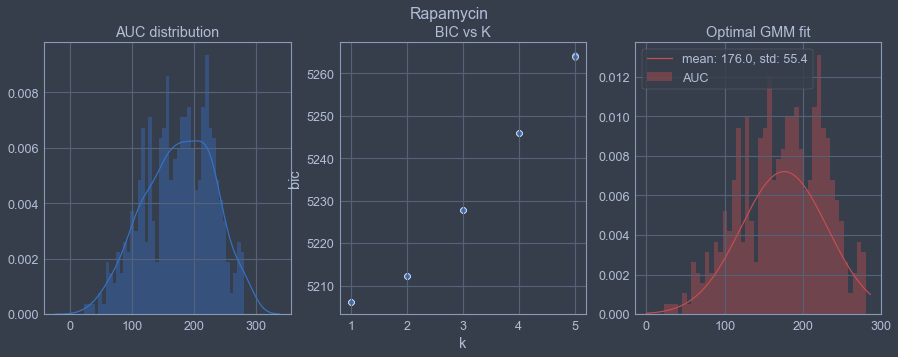

Number of assays (aucs): 17
Optimal K: 1 [BIC=188.8]
GMM fit:
	Mixture Weights: array([1.])
	Means: array([212.46846562])
	Variances: array([2787.11227825])
Class counts: ['class 0: 17']


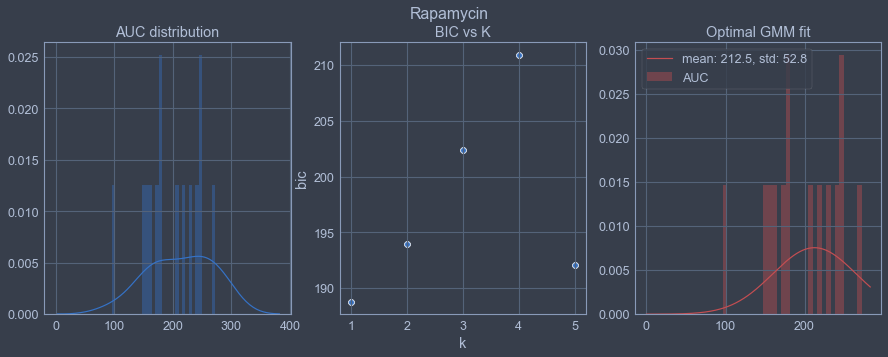

Number of assays (aucs): 495
Optimal K: 1 [BIC=5396.5]
GMM fit:
	Mixture Weights: array([1.])
	Means: array([177.24093136])
	Variances: array([3099.73122504])
Class counts: ['class 0: 495']


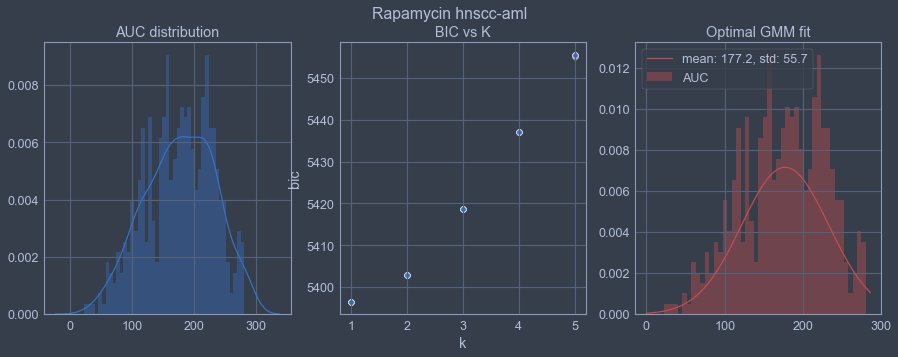

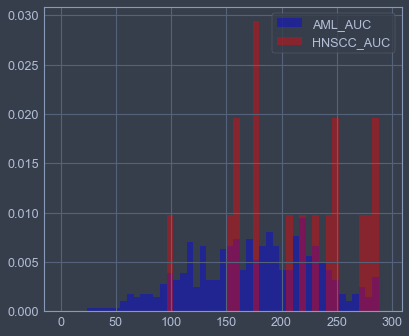

Running permutations...[99.90%]
746
Dasatinib permutation test p-value: 0.007460
---------------------------------------------------------
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
17-AAG (Tanespimycin)
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
---------------------------------------------------------

HNSCC assays:    17
AML assays:      422
Number of assays (aucs): 422
Optimal K: 1 [BIC=4443.6]
GMM fit:
	Mixture Weights: array([1.])
	Means: array([154.50949899])
	Variances: array([2128.91559614])
Class counts: ['class 0: 422']


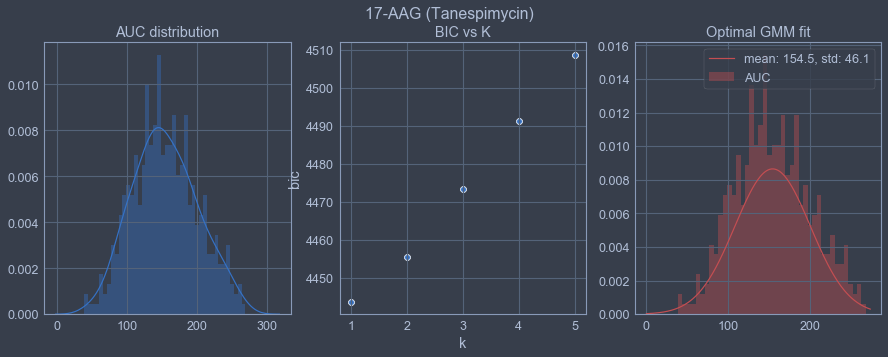

Number of assays (aucs): 17
Optimal K: 1 [BIC=187.5]
GMM fit:
	Mixture Weights: array([1.])
	Means: array([142.10263706])
	Variances: array([2593.17199568])
Class counts: ['class 0: 17']


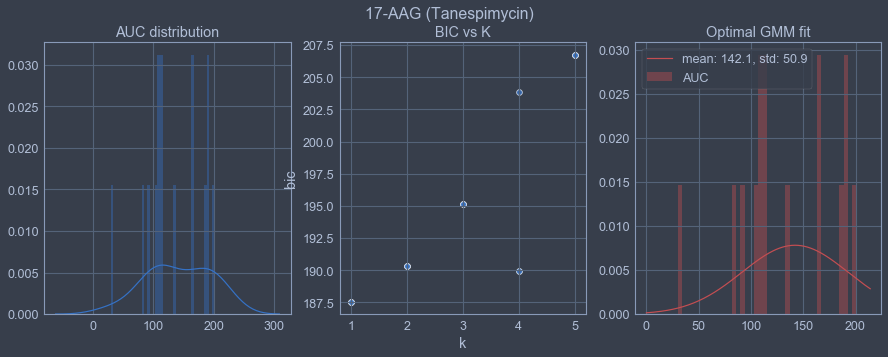

Number of assays (aucs): 439
Optimal K: 1 [BIC=4627.1]
GMM fit:
	Mixture Weights: array([1.])
	Means: array([154.02905103])
	Variances: array([2152.62365561])
Class counts: ['class 0: 439']


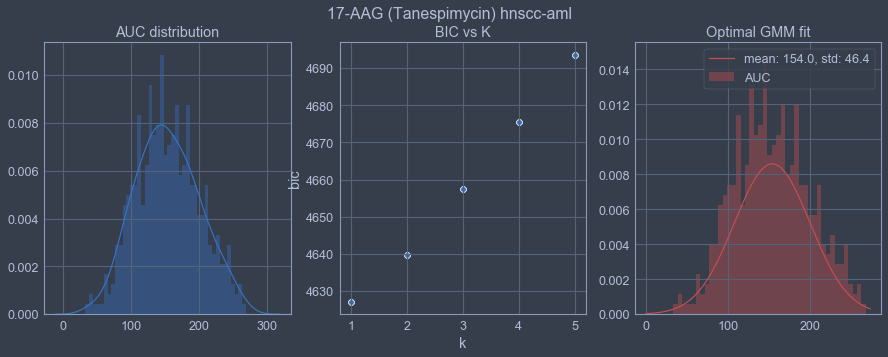

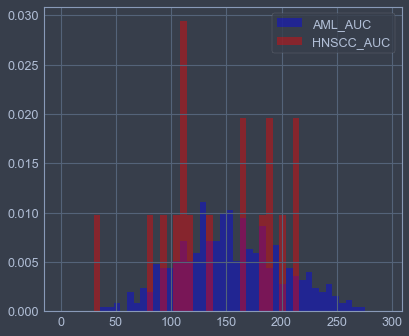

Running permutations...[99.90%]
28054
Dasatinib permutation test p-value: 0.280540
---------------------------------------------------------
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Selumetinib (AZD6244)
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
---------------------------------------------------------

HNSCC assays:    16
AML assays:      433
Number of assays (aucs): 433
Optimal K: 5 [BIC=4831.9]
GMM fit:
	Mixture Weights: array([0.15333835, 0.29483783, 0.19407319, 0.12914925, 0.22860138])
	Means: array([ 95.63644597, 239.00738032, 151.06440004, 281.77366842,
       175.89948627])
	Variances: array([1286.40737068,  557.58173208, 1987.53537673,   27.70942088,
       1293.20958498])
Class counts: ['class 0: 71', 'class 1: 141', 'class 2: 47', 'class 3: 61', 'class 4: 113']


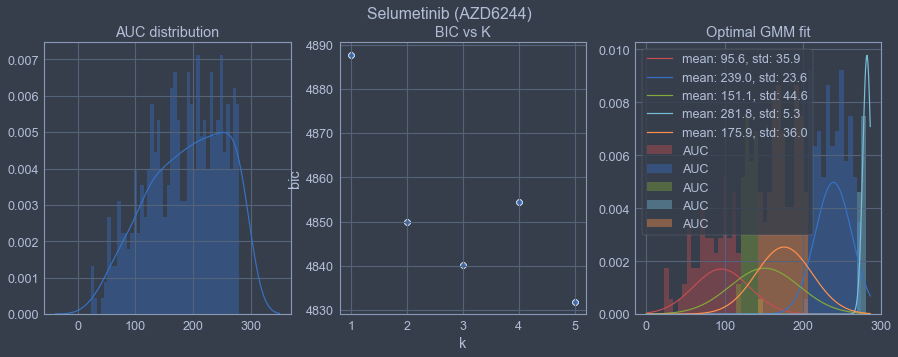

Number of assays (aucs): 16
Optimal K: 4 [BIC=161.9]
GMM fit:
	Mixture Weights: array([0.49999807, 0.18750216, 0.24999976, 0.0625    ])
	Means: array([277.73319668, 231.16232383, 188.68807924, 151.75152427])
	Variances: array([5.60297376e+01, 4.42146550e+01, 2.29101756e+01, 1.00000005e-03])
Class counts: ['class 0: 8', 'class 1: 3', 'class 2: 4', 'class 3: 1']


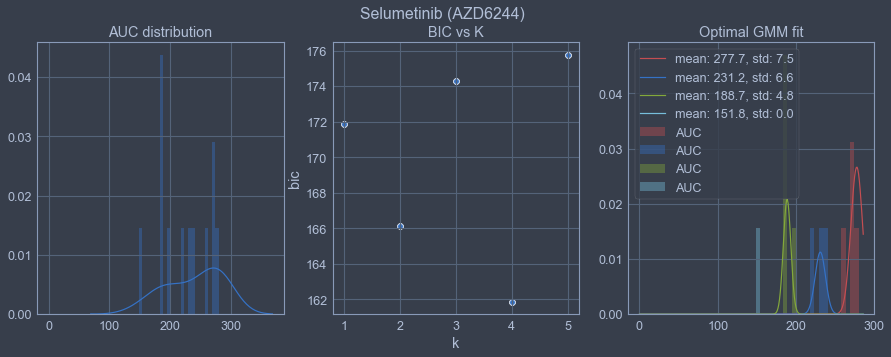

Number of assays (aucs): 449
Optimal K: 3 [BIC=4975.7]
GMM fit:
	Mixture Weights: array([0.14593321, 0.36851018, 0.48555661])
	Means: array([280.683043  , 122.69079105, 219.50574191])
	Variances: array([  37.33787695, 1798.41165434, 1190.76074528])
Class counts: ['class 0: 74', 'class 1: 163', 'class 2: 212']


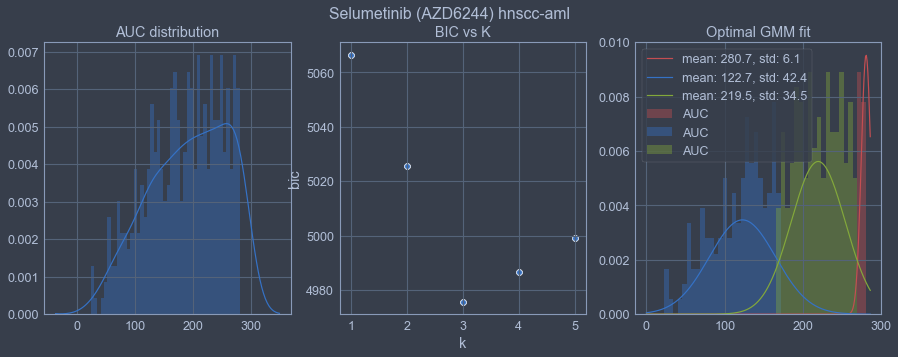

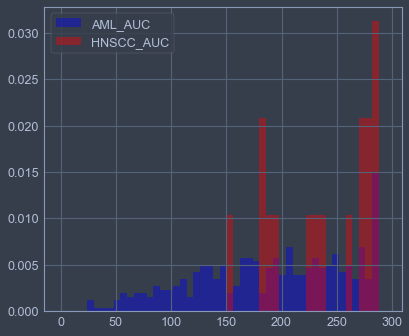

Running permutations...[99.90%]
507
Dasatinib permutation test p-value: 0.005070
---------------------------------------------------------
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
STO609
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
---------------------------------------------------------

HNSCC assays:    17
AML assays:      436
Number of assays (aucs): 436
Optimal K: 4 [BIC=3949.4]
GMM fit:
	Mixture Weights: array([0.24161217, 0.29171633, 0.05540146, 0.41127004])
	Means: array([281.6531562 , 236.67305675, 195.45581545, 263.48593173])
	Variances: array([  14.78975545,  358.57927084, 1374.80492176,   77.37648409])
Class counts: ['class 0: 115', 'class 1: 115', 'class 2: 15', 'class 3: 191']


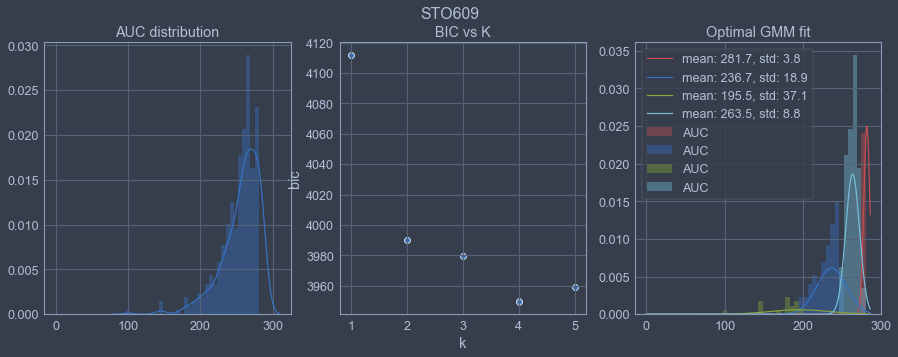

Number of assays (aucs): 17
Optimal K: 3 [BIC=143.5]
GMM fit:
	Mixture Weights: array([0.82352942, 0.11764706, 0.05882352])
	Means: array([274.72440711, 149.54348404, 240.9085346 ])
	Variances: array([4.40641204e+01, 4.94380372e+01, 1.00000012e-03])
Class counts: ['class 0: 14', 'class 1: 2', 'class 2: 1']


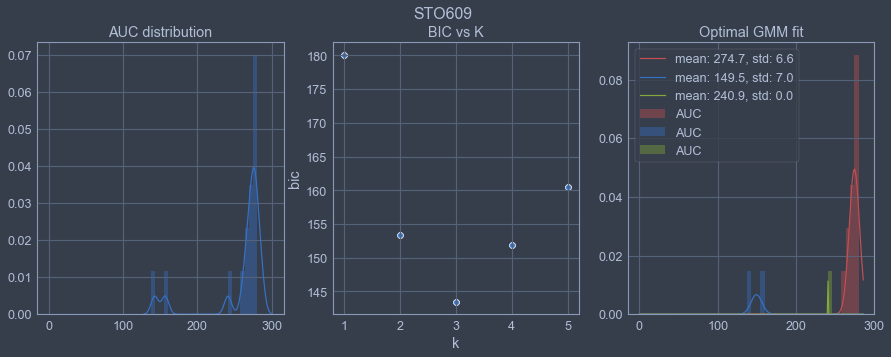

Number of assays (aucs): 453
Optimal K: 4 [BIC=4104.4]
GMM fit:
	Mixture Weights: array([0.40317074, 0.06151082, 0.25259388, 0.28272456])
	Means: array([263.80052509, 191.73789743, 281.37789412, 237.41965566])
	Variances: array([  74.78850169, 1297.7930645 ,   16.09267746,  331.34357843])
Class counts: ['class 0: 193', 'class 1: 21', 'class 2: 126', 'class 3: 113']


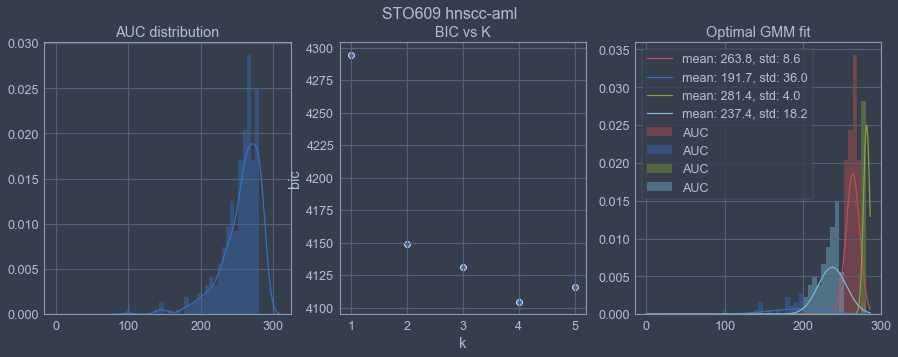

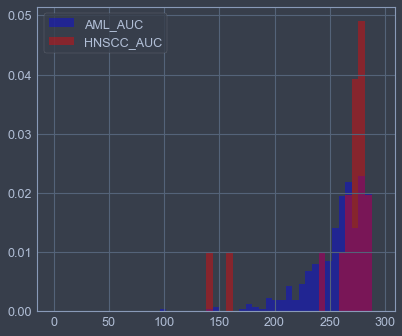

Running permutations...[99.90%]
80195
Dasatinib permutation test p-value: 0.801950
---------------------------------------------------------
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
MGCD-265
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
---------------------------------------------------------

HNSCC assays:    17
AML assays:      421
Number of assays (aucs): 421
Optimal K: 2 [BIC=4437.3]
GMM fit:
	Mixture Weights: array([0.39744535, 0.60255465])
	Means: array([170.23319985, 226.71869457])
	Variances: array([2583.86128434,  883.29490895])
Class counts: ['class 0: 129', 'class 1: 292']


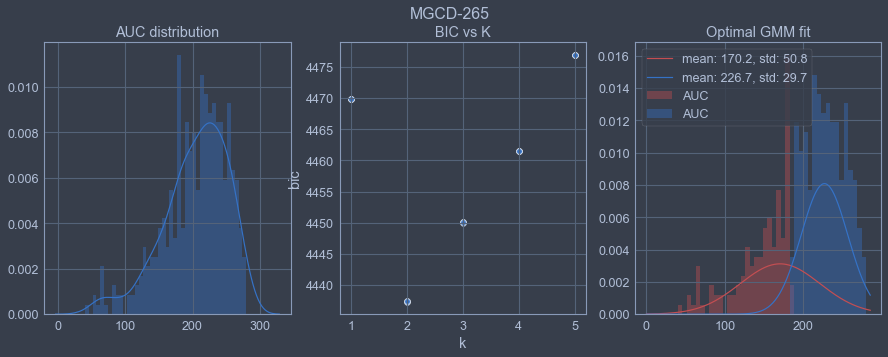

Number of assays (aucs): 17
Optimal K: 3 [BIC=144.1]
GMM fit:
	Mixture Weights: array([0.35551259, 0.05882323, 0.58566418])
	Means: array([281.06580129, 227.66976409, 265.72538265])
	Variances: array([1.70271382e+01, 1.00000010e-03, 8.20068617e+01])
Class counts: ['class 0: 6', 'class 1: 1', 'class 2: 10']


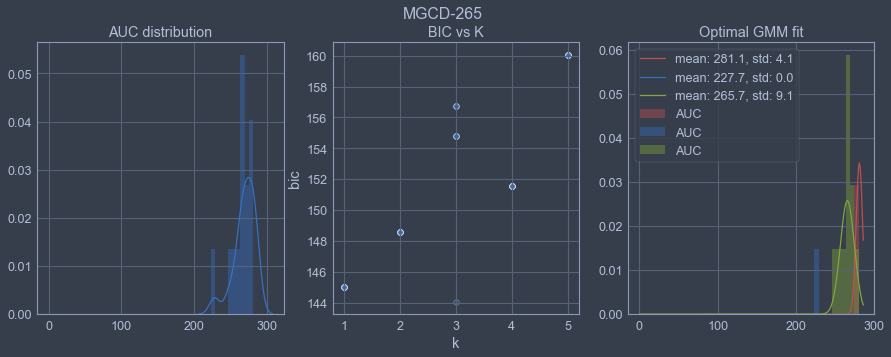

Number of assays (aucs): 438
Optimal K: 2 [BIC=4631.8]
GMM fit:
	Mixture Weights: array([0.58903911, 0.41096089])
	Means: array([230.08630365, 173.37186641])
	Variances: array([ 912.57303272, 2630.93250245])
Class counts: ['class 0: 301', 'class 1: 137']


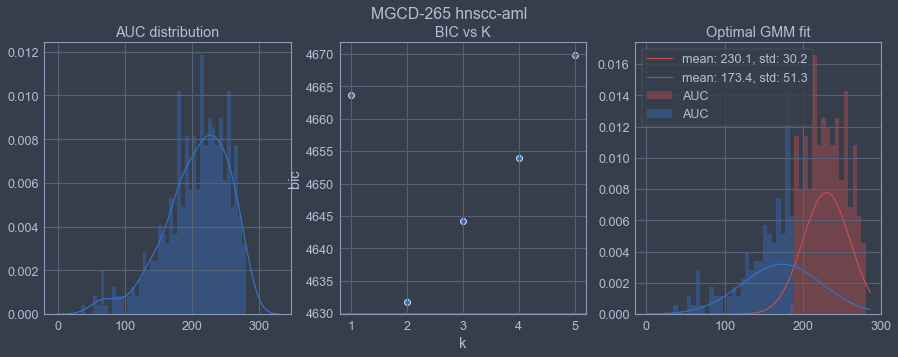

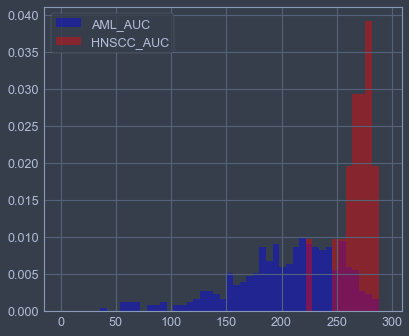

Running permutations...[99.90%]
0
Dasatinib permutation test p-value: 0.000000
---------------------------------------------------------
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
SCH-772984
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
---------------------------------------------------------

HNSCC assays:    15
AML assays:      358
Number of assays (aucs): 358
Optimal K: 2 [BIC=3972.3]
GMM fit:
	Mixture Weights: array([0.53164461, 0.46835539])
	Means: array([133.21946959, 239.32744565])
	Variances: array([1464.75815448, 1072.03915504])
Class counts: ['class 0: 191', 'class 1: 167']


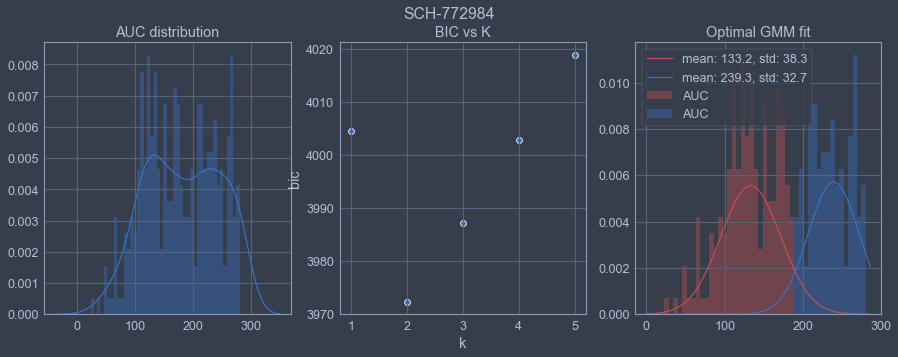

Number of assays (aucs): 15
Optimal K: 1 [BIC=162.3]
GMM fit:
	Mixture Weights: array([1.])
	Means: array([235.87690688])
	Variances: array([2045.93746769])
Class counts: ['class 0: 15']


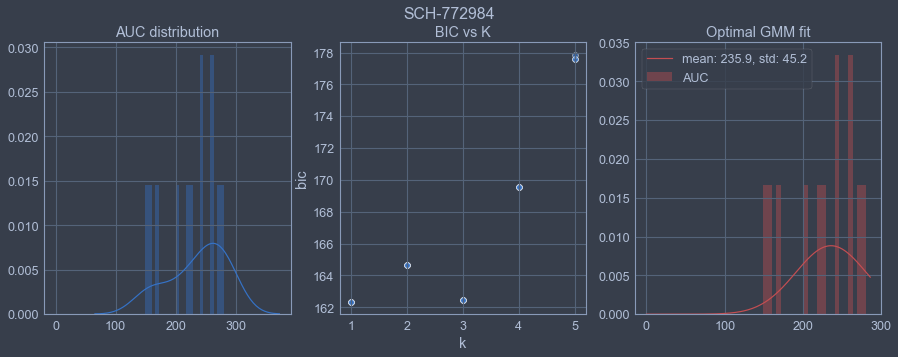

Number of assays (aucs): 373
Optimal K: 2 [BIC=4136.8]
GMM fit:
	Mixture Weights: array([0.52855344, 0.47144656])
	Means: array([134.71698867, 241.4704015 ])
	Variances: array([1497.85415365, 1016.21311892])
Class counts: ['class 0: 199', 'class 1: 174']


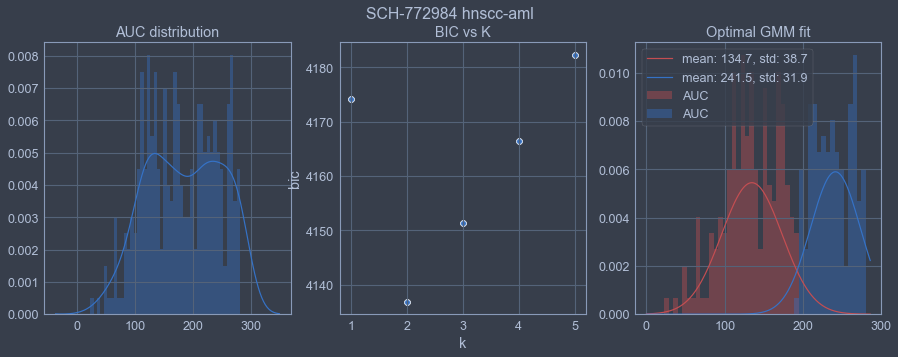

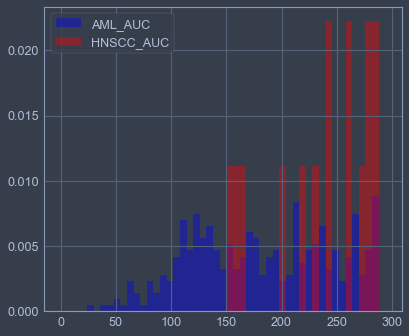

Running permutations...[99.90%]
132
Dasatinib permutation test p-value: 0.001320
---------------------------------------------------------
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Gefitinib
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
---------------------------------------------------------

HNSCC assays:    17
AML assays:      492
Number of assays (aucs): 492
Optimal K: 2 [BIC=4781.7]
GMM fit:
	Mixture Weights: array([0.33129258, 0.66870742])
	Means: array([216.04175397, 253.3594795 ])
	Variances: array([1573.84847907,  403.86181731])
Class counts: ['class 0: 102', 'class 1: 390']


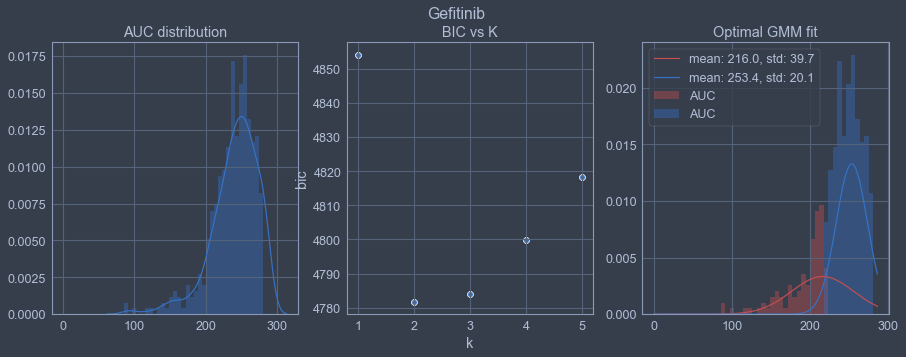

Number of assays (aucs): 17
Optimal K: 1 [BIC=174.4]
GMM fit:
	Mixture Weights: array([1.])
	Means: array([222.58422479])
	Variances: array([1196.61206746])
Class counts: ['class 0: 17']


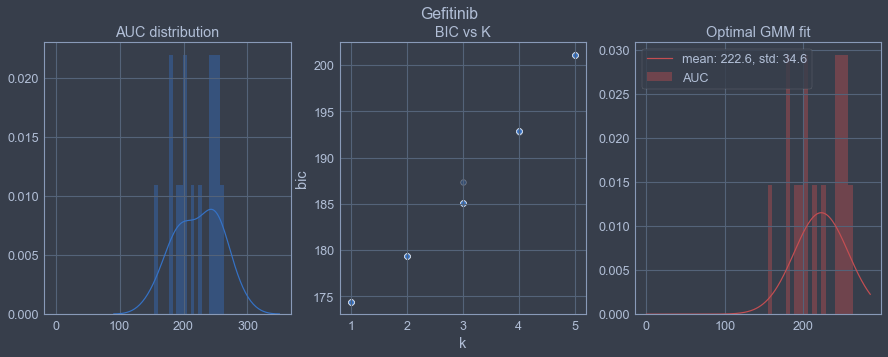

Number of assays (aucs): 509
Optimal K: 2 [BIC=4956.3]
GMM fit:
	Mixture Weights: array([0.65084471, 0.34915529])
	Means: array([253.52710561, 215.87722042])
	Variances: array([ 401.52908211, 1519.95498714])
Class counts: ['class 0: 392', 'class 1: 117']


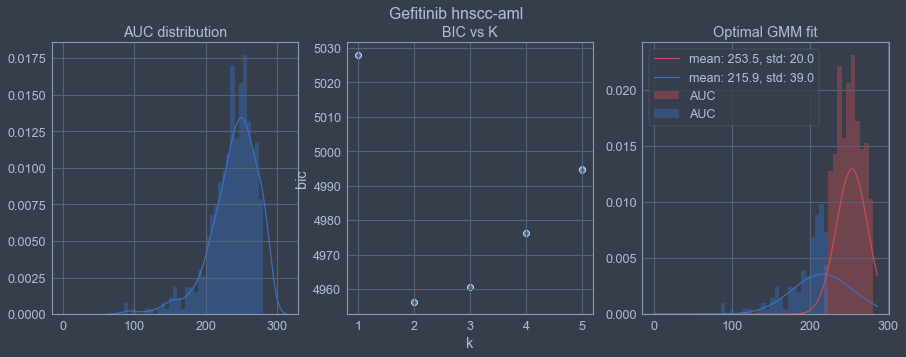

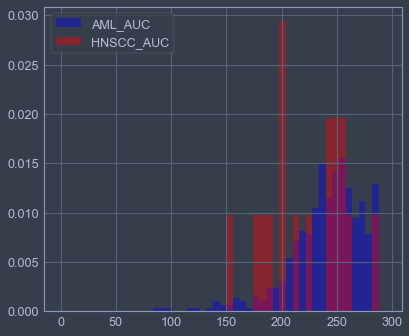

Running permutations...[99.90%]
2543
Dasatinib permutation test p-value: 0.025430
---------------------------------------------------------
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Bortezomib (Velcade)
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
---------------------------------------------------------

HNSCC assays:    17
AML assays:      448
Number of assays (aucs): 448
Optimal K: 1 [BIC=4913.1]
GMM fit:
	Mixture Weights: array([1.])
	Means: array([158.67686228])
	Variances: array([3299.70585455])
Class counts: ['class 0: 448']


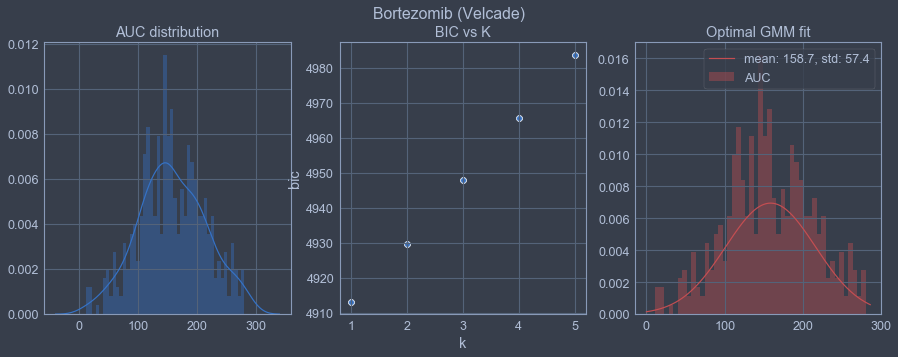

Number of assays (aucs): 17
Optimal K: 1 [BIC=184.1]
GMM fit:
	Mixture Weights: array([1.])
	Means: array([102.60985538])
	Variances: array([2119.32136828])
Class counts: ['class 0: 17']


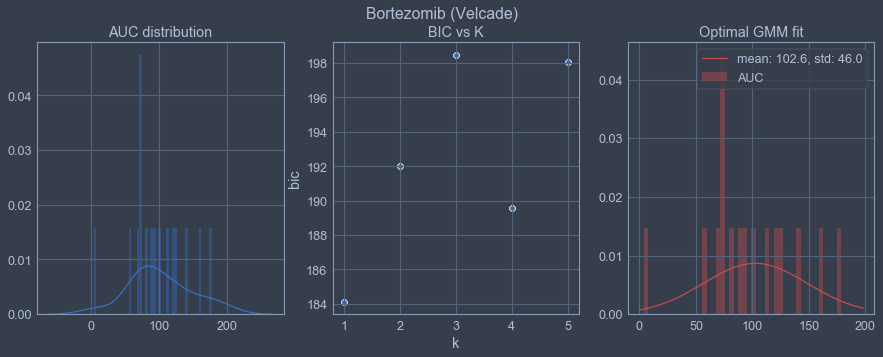

Number of assays (aucs): 465
Optimal K: 1 [BIC=5108.6]
GMM fit:
	Mixture Weights: array([1.])
	Means: array([156.62710074])
	Variances: array([3367.27448531])
Class counts: ['class 0: 465']


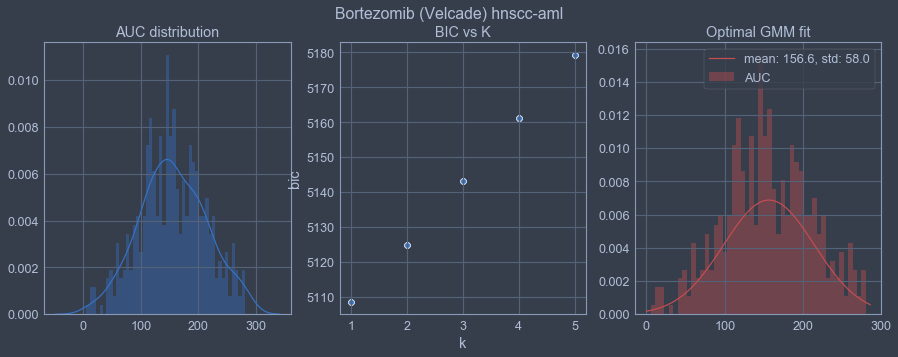

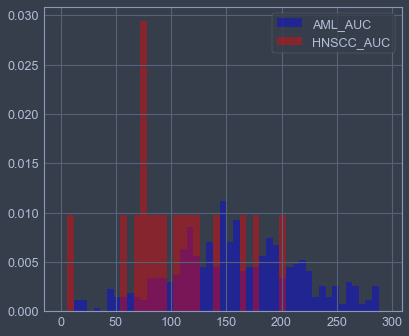

Running permutations...[99.90%]
6
Dasatinib permutation test p-value: 0.000060
---------------------------------------------------------
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
A-674563
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
---------------------------------------------------------

HNSCC assays:    17
AML assays:      438
Number of assays (aucs): 438
Optimal K: 1 [BIC=4651.1]
GMM fit:
	Mixture Weights: array([1.])
	Means: array([151.07041673])
	Variances: array([2329.23070046])
Class counts: ['class 0: 438']


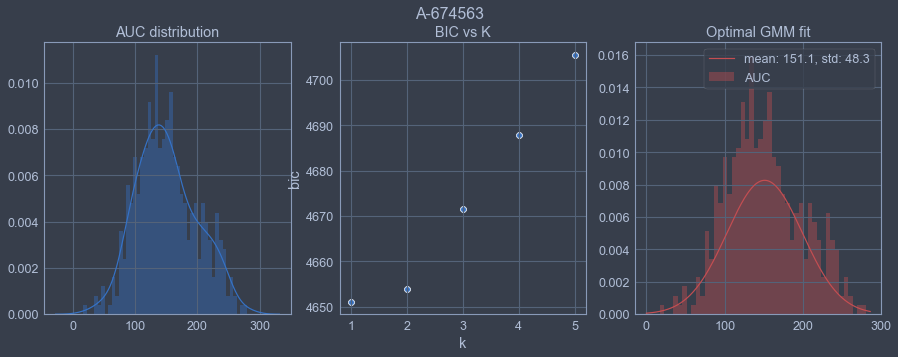

Number of assays (aucs): 17
Optimal K: 3 [BIC=175.6]
GMM fit:
	Mixture Weights: array([0.64136221, 0.29981426, 0.05882353])
	Means: array([223.38192797, 166.80590253,  90.79631394])
	Variances: array([2.87875215e+02, 1.33839394e+02, 1.00000002e-03])
Class counts: ['class 0: 11', 'class 1: 5', 'class 2: 1']


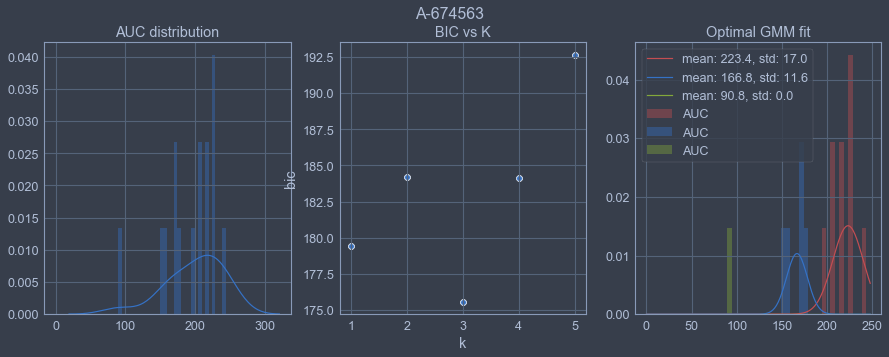

Number of assays (aucs): 455
Optimal K: 1 [BIC=4841.7]
GMM fit:
	Mixture Weights: array([1.])
	Means: array([152.84701231])
	Variances: array([2383.50534535])
Class counts: ['class 0: 455']


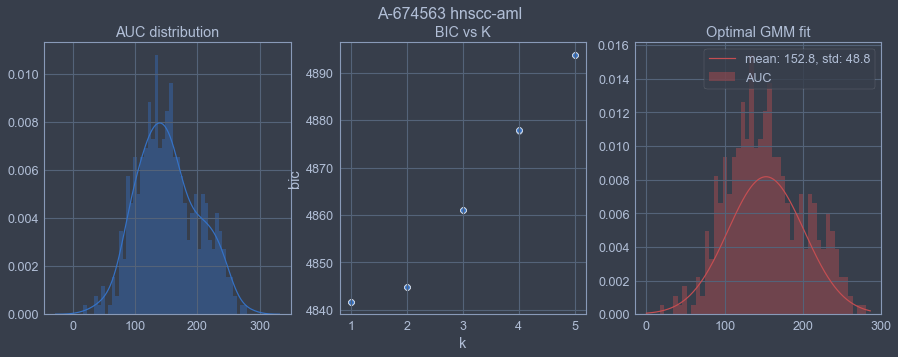

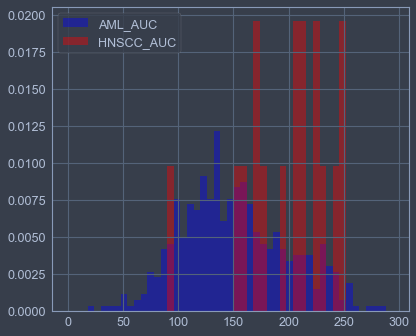

Running permutations...[99.90%]
8
Dasatinib permutation test p-value: 0.000080
---------------------------------------------------------
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
GSK-1838705A
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
---------------------------------------------------------

HNSCC assays:    17
AML assays:      429
Number of assays (aucs): 429
Optimal K: 2 [BIC=4379.6]
GMM fit:
	Mixture Weights: array([0.64441178, 0.35558822])
	Means: array([226.23377434, 193.51224229])
	Variances: array([ 762.09370287, 2589.28618581])
Class counts: ['class 0: 356', 'class 1: 73']


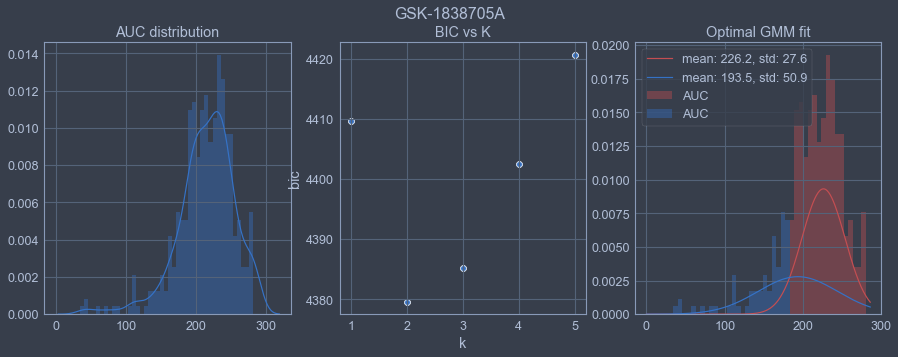

Number of assays (aucs): 17
Optimal K: 1 [BIC=177.0]
GMM fit:
	Mixture Weights: array([1.])
	Means: array([223.29207733])
	Variances: array([1396.9281905])
Class counts: ['class 0: 17']


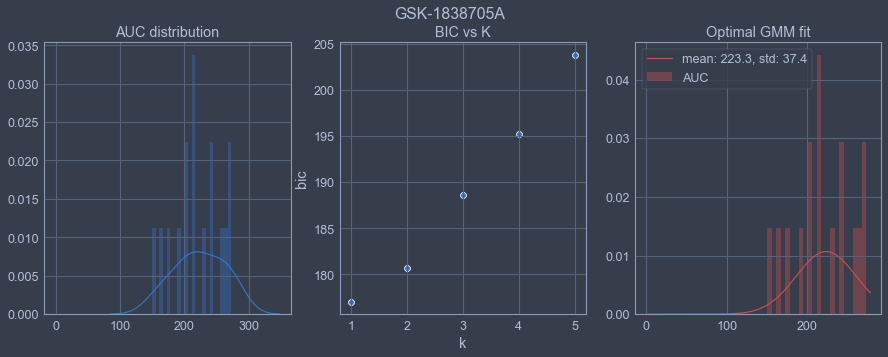

Number of assays (aucs): 446
Optimal K: 2 [BIC=4553.7]
GMM fit:
	Mixture Weights: array([0.63932274, 0.36067726])
	Means: array([226.75212404, 193.97388105])
	Variances: array([ 774.64203683, 2514.78181752])
Class counts: ['class 0: 369', 'class 1: 77']


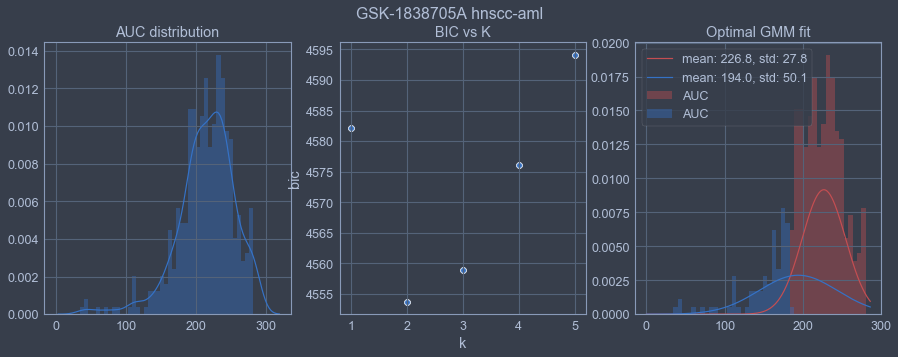

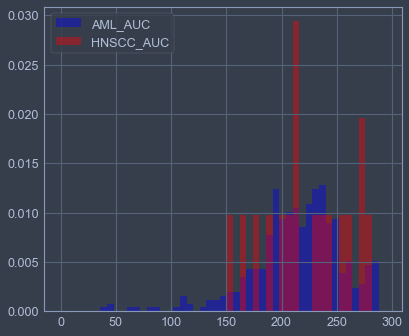

Running permutations...[99.90%]
38886
Dasatinib permutation test p-value: 0.388860
---------------------------------------------------------
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
MLN120B
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
---------------------------------------------------------

HNSCC assays:    10
AML assays:      429
Number of assays (aucs): 429
Optimal K: 2 [BIC=4298.1]
GMM fit:
	Mixture Weights: array([0.29395022, 0.70604978])
	Means: array([198.04981999, 246.5592976 ])
	Variances: array([2515.00648811,  512.24469362])
Class counts: ['class 0: 81', 'class 1: 348']


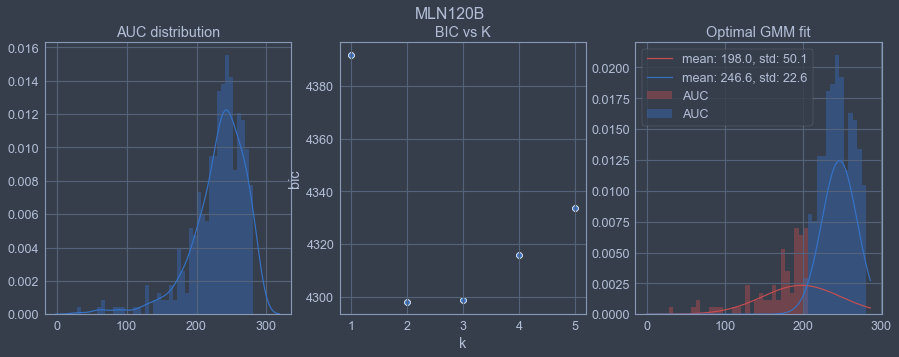

Number of assays (aucs): 10
Optimal K: 2 [BIC=72.6]
GMM fit:
	Mixture Weights: array([0.1, 0.9])
	Means: array([240.37675582, 278.17497378])
	Variances: array([1.00000013e-03, 4.43807201e+01])
Class counts: ['class 0: 1', 'class 1: 9']


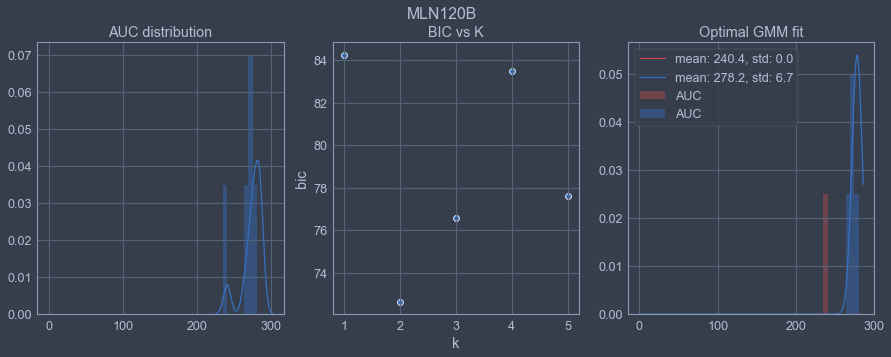

Number of assays (aucs): 439
Optimal K: 3 [BIC=4401.2]
GMM fit:
	Mixture Weights: array([0.49587301, 0.4190536 , 0.08507338])
	Means: array([253.34160741, 225.64310956, 153.71423971])
	Variances: array([ 411.5327024 ,  898.41616319, 2977.22015572])
Class counts: ['class 0: 269', 'class 1: 145', 'class 2: 25']


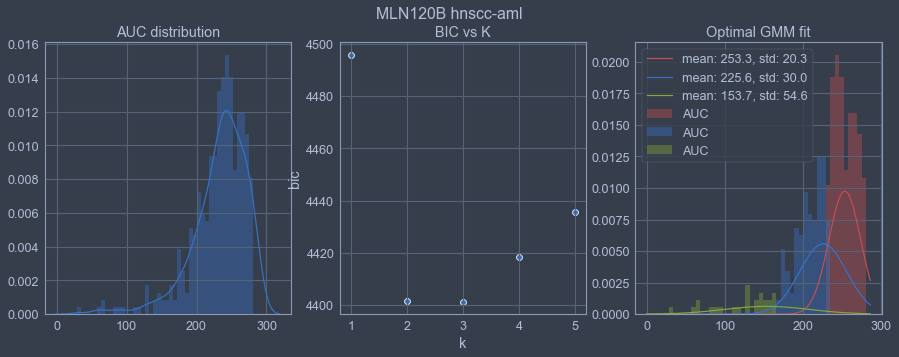

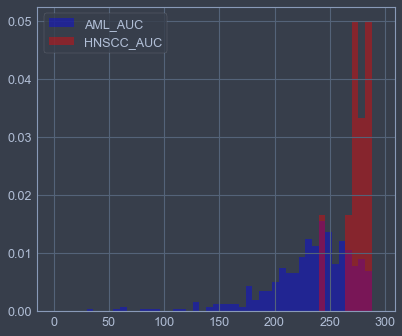

Running permutations...[99.90%]
269
Dasatinib permutation test p-value: 0.002690
---------------------------------------------------------
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Flavopiridol
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
---------------------------------------------------------

HNSCC assays:    17
AML assays:      433
Number of assays (aucs): 433
Optimal K: 2 [BIC=4672.4]
GMM fit:
	Mixture Weights: array([0.66508816, 0.33491184])
	Means: array([103.66651482, 186.28874937])
	Variances: array([ 988.81044947, 3253.09454755])
Class counts: ['class 0: 318', 'class 1: 115']


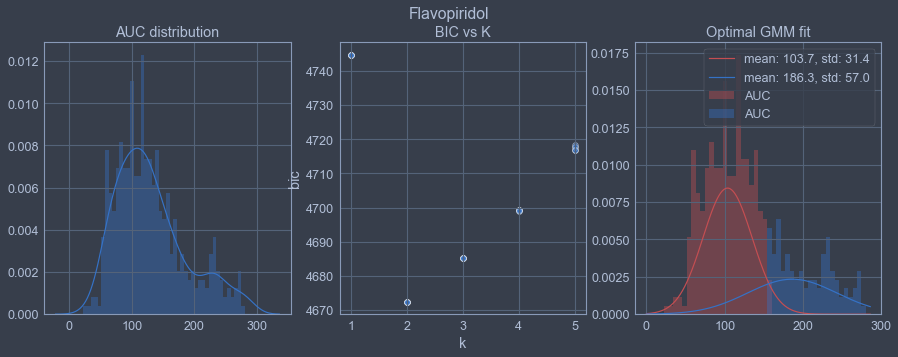

Number of assays (aucs): 17
Optimal K: 1 [BIC=175.4]
GMM fit:
	Mixture Weights: array([1.])
	Means: array([124.76139218])
	Variances: array([1267.53140337])
Class counts: ['class 0: 17']


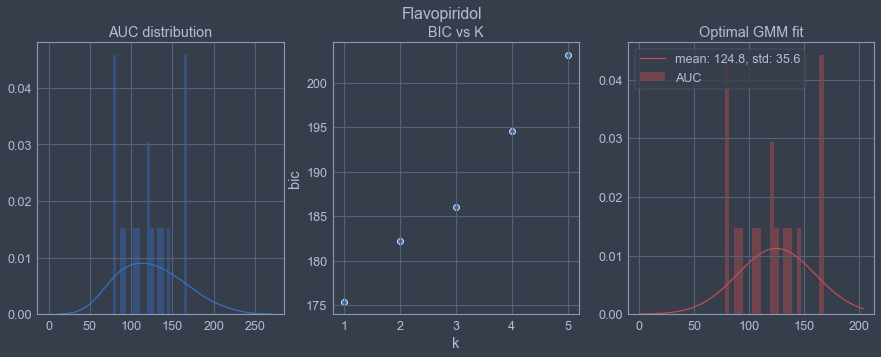

Number of assays (aucs): 450
Optimal K: 2 [BIC=4846.2]
GMM fit:
	Mixture Weights: array([0.66622111, 0.33377889])
	Means: array([104.06270298, 185.03408958])
	Variances: array([ 982.04746674, 3240.20720134])
Class counts: ['class 0: 331', 'class 1: 119']


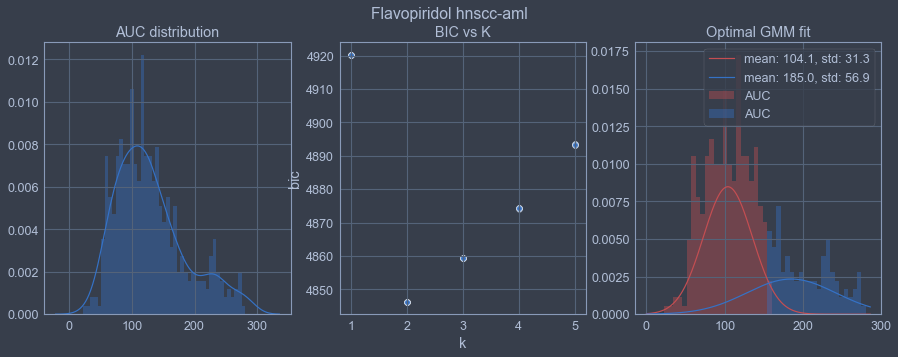

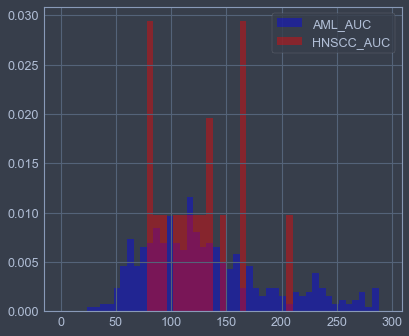

Running permutations...[99.90%]
64271
Dasatinib permutation test p-value: 0.642710
---------------------------------------------------------
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Imatinib
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
---------------------------------------------------------

HNSCC assays:    12
AML assays:      511
Number of assays (aucs): 511
Optimal K: 3 [BIC=5165.5]
GMM fit:
	Mixture Weights: array([0.43649856, 0.13105134, 0.43245011])
	Means: array([252.62014183, 172.5744297 , 227.366578  ])
	Variances: array([ 470.51400222, 3191.54285991,  882.98703283])
Class counts: ['class 0: 275', 'class 1: 40', 'class 2: 196']


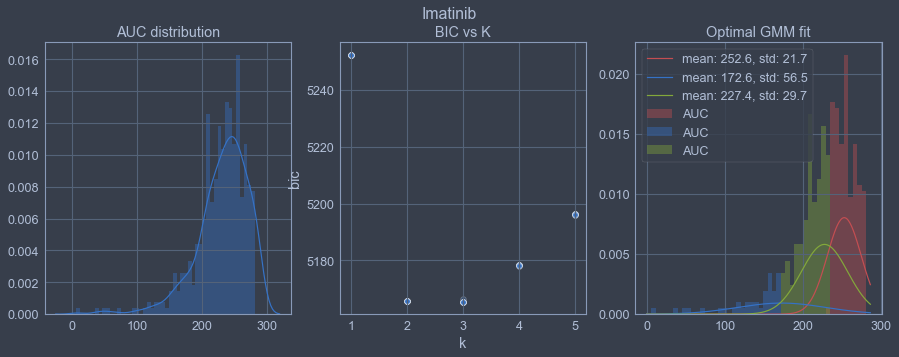

Number of assays (aucs): 12
Optimal K: 5 [BIC=63.2]
GMM fit:
	Mixture Weights: array([0.16666667, 0.08333333, 0.3333333 , 0.25      , 0.1666667 ])
	Means: array([276.41450267, 284.81676973, 280.87470159, 286.21753762,
       282.75862477])
	Variances: array([0.31042927, 0.001     , 0.04638306, 0.00857553, 0.09145358])
Class counts: ['class 0: 2', 'class 1: 1', 'class 2: 4', 'class 3: 3', 'class 4: 2']


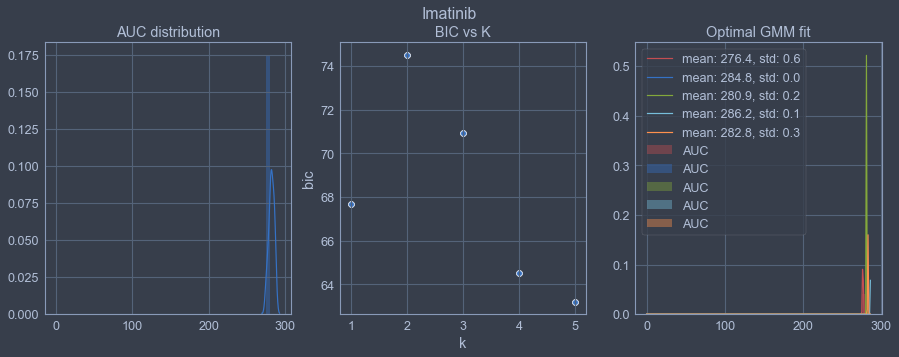

Number of assays (aucs): 523
Optimal K: 3 [BIC=5291.1]
GMM fit:
	Mixture Weights: array([0.43476605, 0.11966333, 0.44557063])
	Means: array([256.13009846, 171.68584727, 225.4992784 ])
	Variances: array([ 428.41479533, 3348.43668277,  872.19695912])
Class counts: ['class 0: 273', 'class 1: 33', 'class 2: 217']


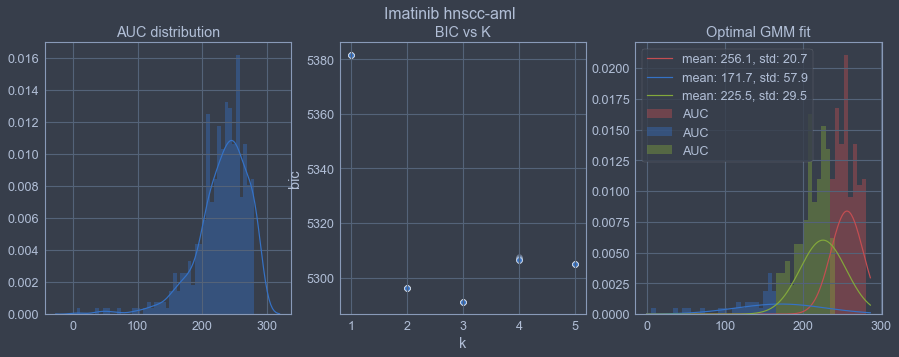

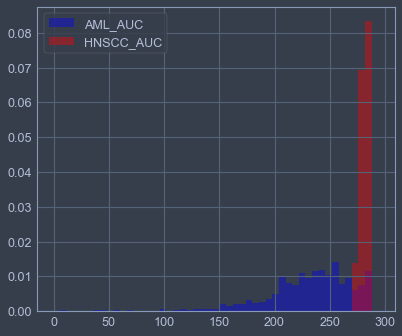

Running permutations...[99.90%]
22
Dasatinib permutation test p-value: 0.000220
---------------------------------------------------------
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
NVP-ADW742
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
---------------------------------------------------------

HNSCC assays:    17
AML assays:      415
Number of assays (aucs): 415
Optimal K: 2 [BIC=4184.6]
GMM fit:
	Mixture Weights: array([0.61551839, 0.38448161])
	Means: array([231.11355308, 197.1292676 ])
	Variances: array([ 648.79332419, 1978.51115865])
Class counts: ['class 0: 321', 'class 1: 94']


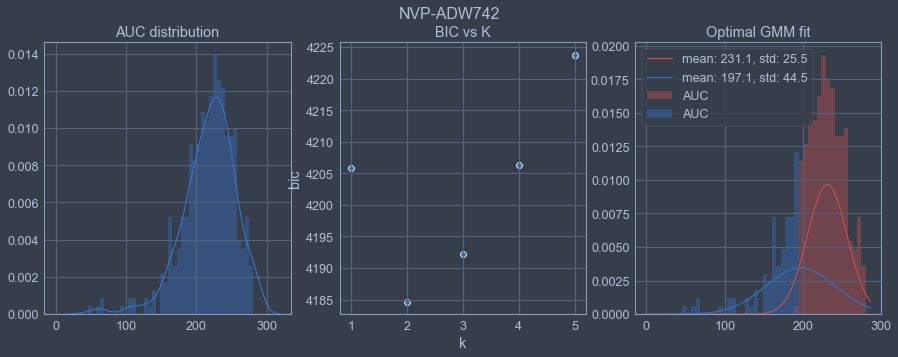

Number of assays (aucs): 17
Optimal K: 2 [BIC=169.9]
GMM fit:
	Mixture Weights: array([0.54126442, 0.45873558])
	Means: array([221.63512323, 278.63532448])
	Variances: array([432.16215046,  46.35083761])
Class counts: ['class 0: 9', 'class 1: 8']


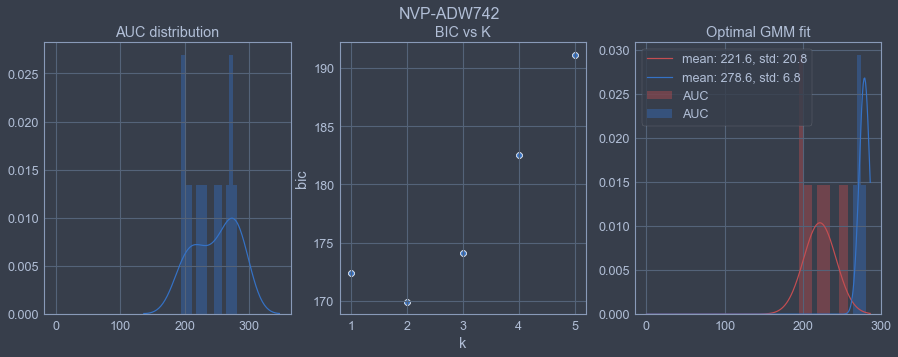

Number of assays (aucs): 432
Optimal K: 2 [BIC=4365.6]
GMM fit:
	Mixture Weights: array([0.60228835, 0.39771165])
	Means: array([232.42344812, 199.21832493])
	Variances: array([ 682.10366967, 1954.28798669])
Class counts: ['class 0: 331', 'class 1: 101']


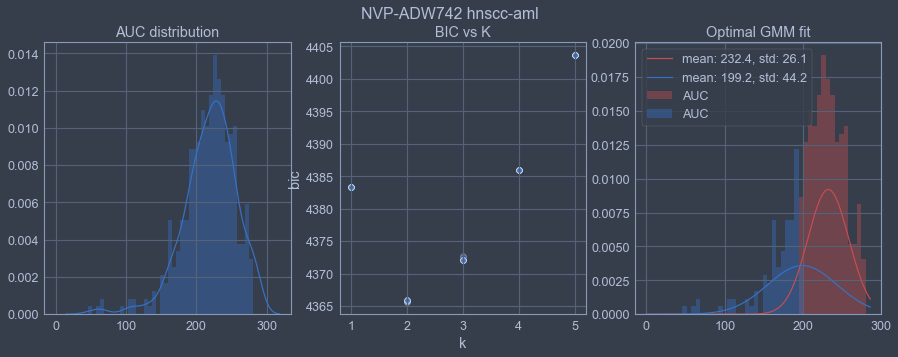

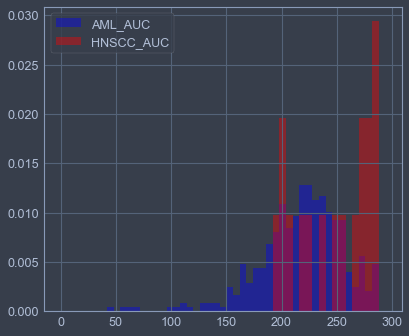

Running permutations...[99.90%]
220
Dasatinib permutation test p-value: 0.002200
---------------------------------------------------------
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Sorafenib
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
---------------------------------------------------------

HNSCC assays:    17
AML assays:      505
Number of assays (aucs): 505
Optimal K: 2 [BIC=5406.4]
GMM fit:
	Mixture Weights: array([0.42476075, 0.57523925])
	Means: array([160.43097496, 220.70232329])
	Variances: array([2577.01244736, 1141.4331894 ])
Class counts: ['class 0: 173', 'class 1: 332']


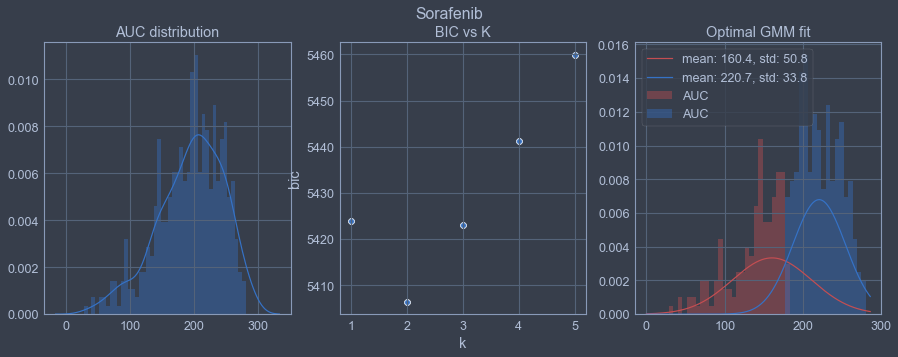

Number of assays (aucs): 17
Optimal K: 1 [BIC=151.4]
GMM fit:
	Mixture Weights: array([1.])
	Means: array([259.10442709])
	Variances: array([310.30304888])
Class counts: ['class 0: 17']


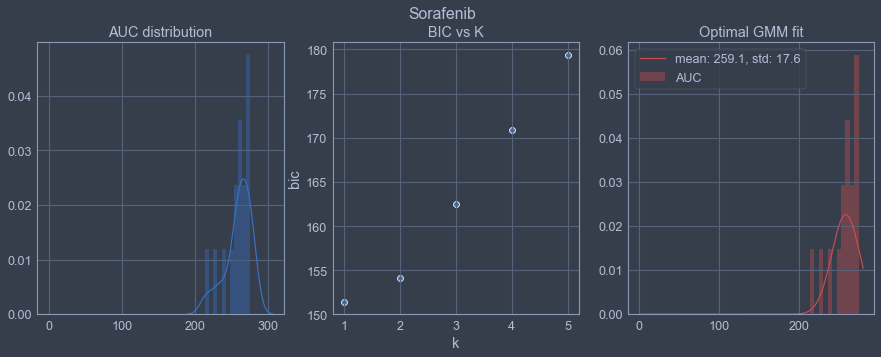

Number of assays (aucs): 522
Optimal K: 2 [BIC=5596.3]
GMM fit:
	Mixture Weights: array([0.42367792, 0.57632208])
	Means: array([161.71438387, 223.26230414])
	Variances: array([2608.67606836, 1148.36266613])
Class counts: ['class 0: 180', 'class 1: 342']


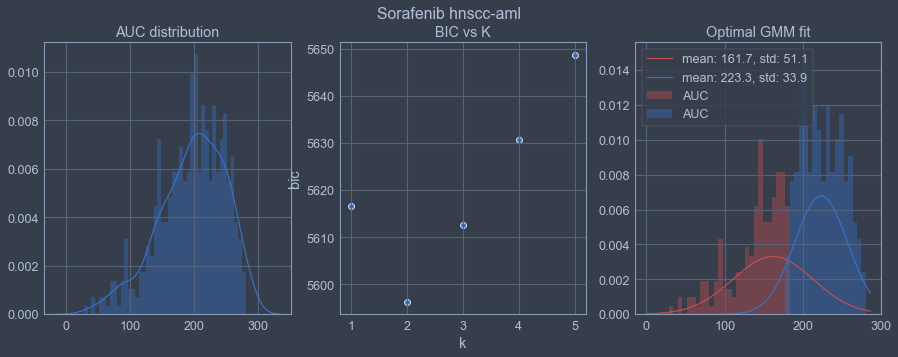

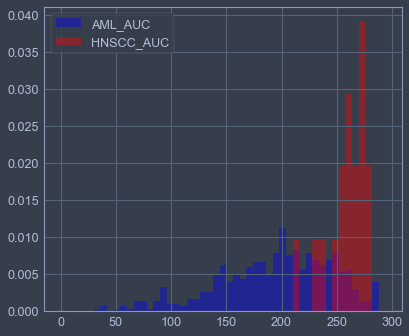

Running permutations...[99.90%]
0
Dasatinib permutation test p-value: 0.000000
---------------------------------------------------------
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
INK-128
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
---------------------------------------------------------

HNSCC assays:    17
AML assays:      436
Number of assays (aucs): 436
Optimal K: 1 [BIC=4684.9]
GMM fit:
	Mixture Weights: array([1.])
	Means: array([128.60194517])
	Variances: array([2642.44890348])
Class counts: ['class 0: 436']


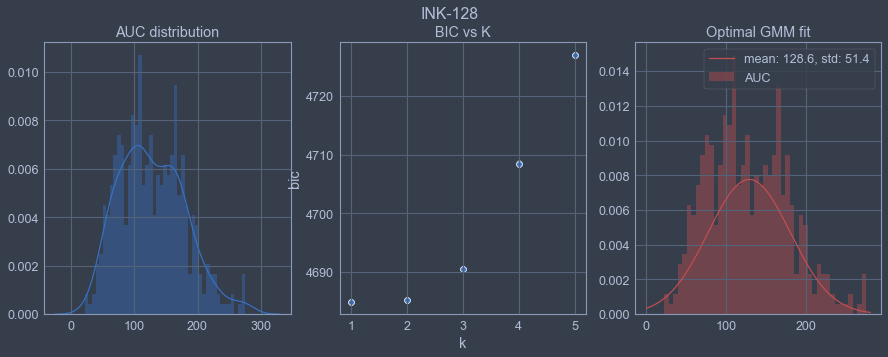

Number of assays (aucs): 17
Optimal K: 3 [BIC=179.7]
GMM fit:
	Mixture Weights: array([0.11792943, 0.23578104, 0.64628954])
	Means: array([ 38.07824608, 164.54098077,  81.5148204 ])
	Variances: array([ 76.44918192, 495.70757433,  63.92442256])
Class counts: ['class 0: 2', 'class 1: 4', 'class 2: 11']


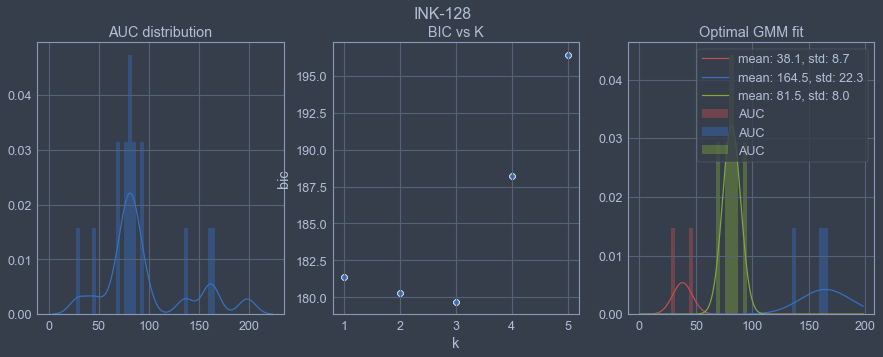

Number of assays (aucs): 453
Optimal K: 2 [BIC=4865.8]
GMM fit:
	Mixture Weights: array([0.45921674, 0.54078326])
	Means: array([160.86749645,  98.93841395])
	Variances: array([2243.83081391, 1232.842173  ])
Class counts: ['class 0: 190', 'class 1: 263']


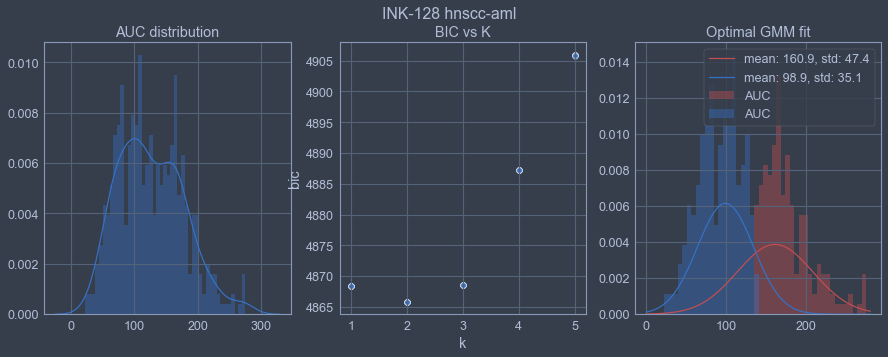

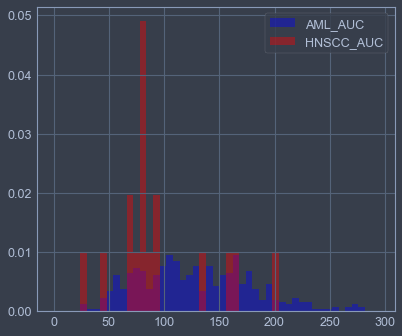

Running permutations...[99.90%]
988
Dasatinib permutation test p-value: 0.009880
---------------------------------------------------------
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Lapatinib
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
---------------------------------------------------------

HNSCC assays:    17
AML assays:      485
Number of assays (aucs): 485
Optimal K: 2 [BIC=4735.0]
GMM fit:
	Mixture Weights: array([0.37159515, 0.62840485])
	Means: array([212.13786003, 243.08928529])
	Variances: array([1530.34760838,  455.4886863 ])
Class counts: ['class 0: 101', 'class 1: 384']


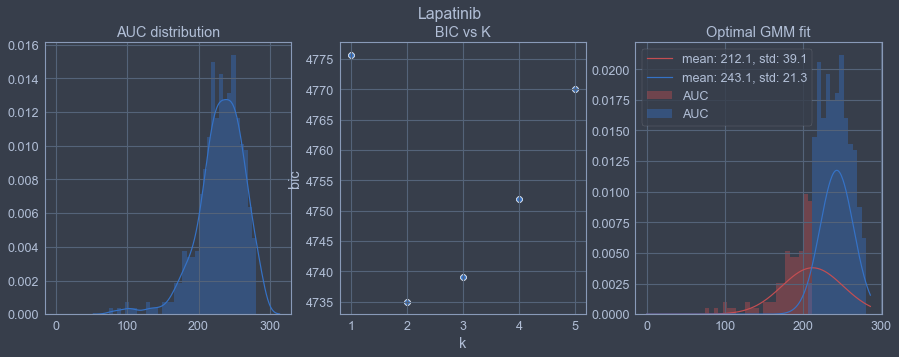

Number of assays (aucs): 17
Optimal K: 3 [BIC=179.8]
GMM fit:
	Mixture Weights: array([0.39461272, 0.54656375, 0.05882353])
	Means: array([252.6893726 , 188.64748528, 106.25441812])
	Variances: array([3.13345503e+02, 2.56306922e+02, 1.00000003e-03])
Class counts: ['class 0: 7', 'class 1: 9', 'class 2: 1']


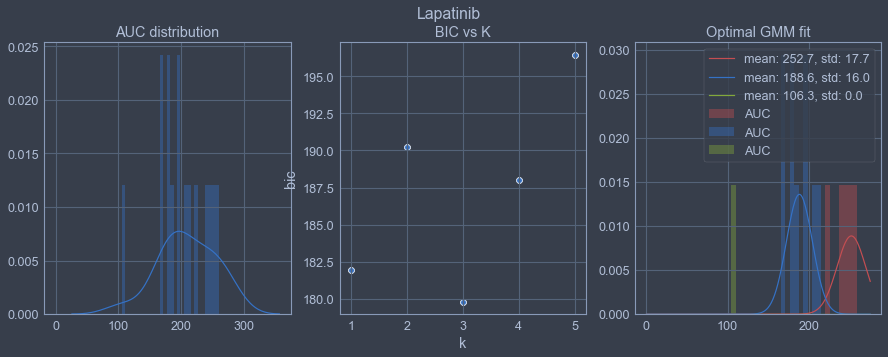

Number of assays (aucs): 502
Optimal K: 2 [BIC=4920.3]
GMM fit:
	Mixture Weights: array([0.61148481, 0.38851519])
	Means: array([243.49125273, 210.89062867])
	Variances: array([ 456.61022085, 1518.85155766])
Class counts: ['class 0: 382', 'class 1: 120']


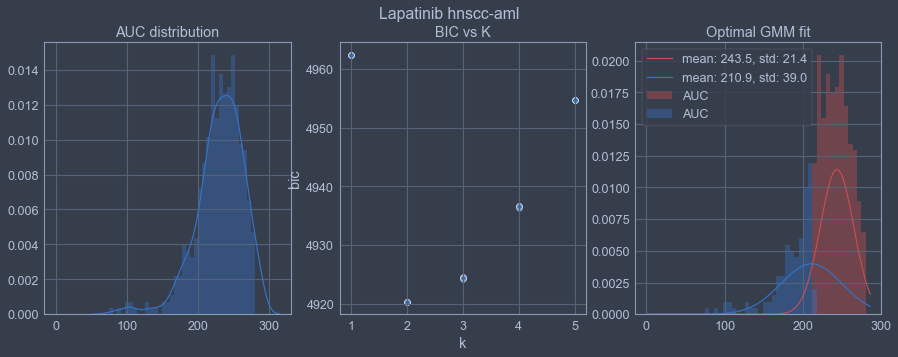

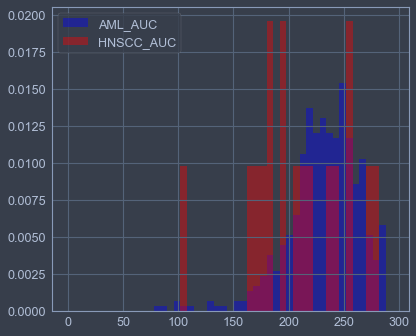

Running permutations...[99.90%]
729
Dasatinib permutation test p-value: 0.007290


In [21]:
for inhib in shared_drugs: 
    aml_ = aml_aucs[aml_aucs.inhibitor == inhib].drop_duplicates().auc.values.reshape(-1,1)
    hnscc_ = 100*HNSCC_all[HNSCC_all.inhibitor == inhib].auc.drop_duplicates().values.reshape(-1,1) #hnscc is weighted by 1/100
    
    if aml_.shape[0] + hnscc_.shape[0] > 300: 
        test_distribution_similarity(aml_, hnscc_, inhib=inhib, perms=1e5)

In [22]:
AML_Dasatinib = aml_aucs[aml_aucs['inhibitor'] == 'Sorafenib']
print('Number of AML Sorafenib assays: %d' %len(AML_Dasatinib))
AML_Dasatinib.head()

Number of AML Sorafenib assays: 505


inhibitor    lab_id         auc
427287  Sorafenib  11-00261  232.933886
427294  Sorafenib  11-00487  181.911965
427301  Sorafenib  12-00023  189.034206
427308  Sorafenib  12-00032  184.248305
427315  Sorafenib  12-00066  171.013986

In [23]:
HNSCC_Dasatinib = HNSCC_auc[HNSCC_auc['inhibitor'] == 'Sorafenib'].drop_duplicates()
print('Number of HNSCC Sorafenib assays: %d' %len(HNSCC_Dasatinib))
HNSCC_Dasatinib.head()

Number of HNSCC Sorafenib assays: 17


lab_id  inhibitor       auc call
129    10004  Sorafenib  2.731822  int
2475   10139  Sorafenib  2.707063  int
4821   10308  Sorafenib  2.812098  res
6015   10309  Sorafenib  2.616760  int
7209   10314  Sorafenib  2.564023  int

------------------------------------------------
Inhibitor:  AML_Dasatinib
------------------------------------------------
Number of assays (aucs): 505
Optimal K: 2 [BIC=5406.4]
GMM fit:
	Mixture Weights: array([0.57523925, 0.42476075])
	Means: array([220.70232329, 160.43097496])
	Variances: array([1141.4331894 , 2577.01244736])
Class counts: ['class 0: 332', 'class 1: 173']


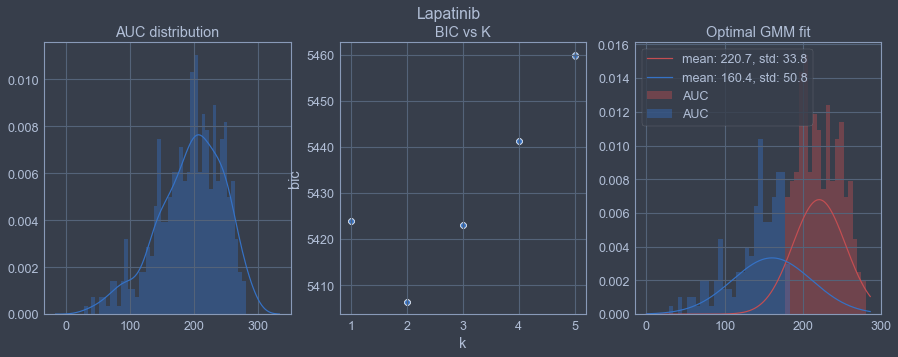

------------------------------------------------
Inhibitor:  HNSCC_Dasatinib
------------------------------------------------
Number of assays (aucs): 17
Optimal K: 1 [BIC=151.4]
GMM fit:
	Mixture Weights: array([1.])
	Means: array([259.10442709])
	Variances: array([310.30304888])
Class counts: ['class 0: 17']


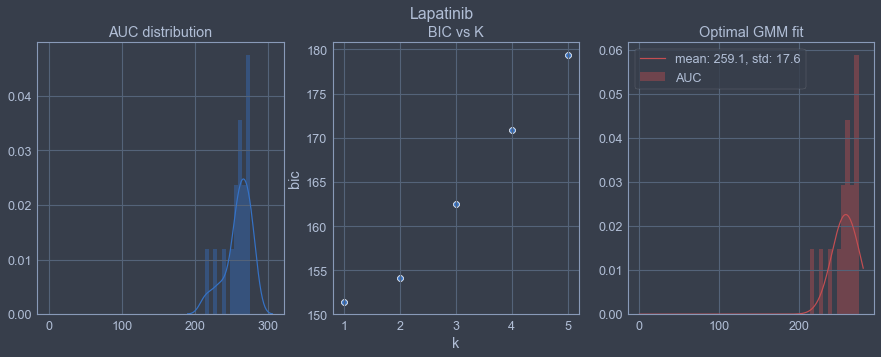

In [24]:
print('------------------------------------------------')
print('Inhibitor:  %s' %'AML_Dasatinib')
print('------------------------------------------------')
aml_= AML_Dasatinib.auc.values.reshape(-1,1)
c = test_multimodal_fits(aml_, ntests=10, kmax=6, inhib=inhib, plot=True)

print('------------------------------------------------')
print('Inhibitor:  %s' %'HNSCC_Dasatinib')
print('------------------------------------------------')
hnscc_=100*HNSCC_Dasatinib.auc.values.reshape(-1,1)
c = test_multimodal_fits(hnscc_, ntests=10, kmax=6, inhib=inhib, plot=True)

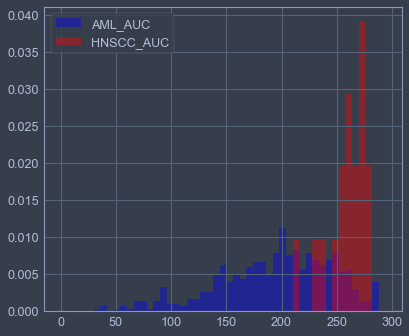

In [25]:
nbins=50
bin_ = np.arange(0,300,300/nbins)

plt.figure()
plt.hist(aml_,color='blue',label='AML_AUC',normed=True,alpha=0.4,bins=bin_)
plt.hist(hnscc_,color='red',label='HNSCC_AUC',normed=True,alpha=0.4,bins=bin_)
plt.legend()
plt.show()

In [26]:
pval = permutation_test(aml_, hnscc_, n=1e6, verbose=True, return_prob=True)

print('Dasatinib permutation test p-value: %f' %pval)

Running permutations...[100.00%]
4
Dasatinib permutation test p-value: 0.000004


# Drug response associated mutations 



In [27]:
aml_var_all = pd.read_csv('./../data/vizome_beatAML_variants.csv', skiprows=[0,1,2])
#[aml_var_all.tumor_only == True]
aml_var = aml_var_all.dropna()[['sample_id', 'gene', 'chr','start','end','ref','alt','variant','sift']]

aml_var = aml_var.rename(columns={'sample_id':'lab_id'})

print(aml_var.head())

print(aml_var[['chr','start','end','ref','alt']].head())

print('Number of genes mutated: %d' %len(aml_var.gene.unique()))
print('Number of unique mutations: %d' %aml_var[['chr','start','end','ref','alt']].drop_duplicates().shape[0])

mut_cnt = aml_var.groupby('gene').count()['lab_id'].sort_values()
mult_patients = mut_cnt.index[mut_cnt > 20]
#aml_variants = aml_var[aml_var['lab_id'].isin(mult_patients)]

shared_mutations = [x for x in mult_patients]
print(shared_mutations)
print(aml_var.groupby('gene').count()['lab_id'].sort_values())

aml_var = aml_var[aml_var['gene'].isin(shared_mutations)]

aml_var.head()

FileNotFoundError: File b'./../data/vizome_beatAML_variants.csv' does not exist

In [ ]:
# convert variants to matrix format 

genes = pd.Series( aml_var.gene.unique() )

res = []
for lab_id in aml_var.lab_id.unique(): 
    D = aml_var[aml_var['lab_id'] == lab_id]
    x = genes.isin( D['gene'] ).tolist()
    res.append( [lab_id] + [str(int(xx)) for xx in x] )

res = pd.DataFrame( res, columns=['lab_id'] + genes.tolist() )

res.head()

MAT_VAR = res 

print('matrix variant shape: %s' %str(res.shape))
print(MAT_VAR.head())

In [ ]:
print( aml_aucs.head() )

aml_aucs['lab_id']=aml_aucs['lab_id'].astype(str)
MAT_VAR['lab_id']=MAT_VAR['lab_id'].astype(str)

aml_auc_w_var = aml_aucs.merge(right=MAT_VAR, how='inner', on=['lab_id'])
aml_auc_w_var.head(5)

In [ ]:
Dasatinib = aml_auc_w_var[aml_auc_w_var['inhibitor'] == 'Dasatinib']

print('Dasatinib auc and variants shape: %s' %str(Dasatinib.shape))

aucs = Dasatinib.auc.values.reshape(-1,1)
X = Dasatinib[genes]
Y = test_multimodal_fits(aucs, inhib='Dasatinib', override_k=2)

X_embedded = TSNE(n_components=2).fit_transform(X)
df = pd.DataFrame( {'x1':X_embedded[:,0], 'x2':X_embedded[:,1], 'label':Y} )

plt.figure() 
sbn.scatterplot(x='x1', y='x2', hue='label', data=df)
plt.show()

In [ ]:
reg = ElasticNet().fit(X, Y)

yhat = reg.predict(X)

pred = (yhat > 0.5)*1

acc = sum([a == b for a,b in zip(pred, Y)]*1) / len(Y)
print('Elastic Net accuracy: %.2f' %acc)

fpr, tpr, thresholds = metrics.roc_curve(Y, yhat, pos_label=1)
EN_auc = metrics.auc(fpr, tpr)
print('Elastic Net AUC: %.2f' %EN_auc)

plt.figure()
plt.plot(fpr,tpr,'r--')
plt.show()



logit = LogisticRegression().fit(X,Y)

yhat = logit.predict(X)
pred = (yhat > 0.5)*1
print(pred)

acc = sum([a == b for a,b in zip(pred, Y)]*1) / len(Y)
print('Logistic Regression accuracy: %.2f' %acc)

fpr, tpr, thresholds = metrics.roc_curve(Y, yhat, pos_label=1)
EN_auc = metrics.auc(fpr, tpr)
print('Logistic Regression AUC: %.2f' %EN_auc)

plt.figure()
plt.plot(fpr,tpr,'r--')
plt.show()

print('---------------------------------------------------')
print('STATSMODEL LOGIT')
print('---------------------------------------------------')

X2 = X.values.astype(int)
logit_sm = sm.Logit(Y, sm.add_constant(X2)).fit(method='lbfgs', maxiter=500)
yhat = logit_sm.predict(sm.add_constant(X2))

cutoff = 0.9
pred = (yhat > cutoff)*1

acc = sum([a == b for a,b in zip(pred, Y)]*1) / len(Y)
print('Logistic Regression accuracy: %.2f' %acc)

fpr, tpr, thresholds = metrics.roc_curve(Y, yhat, pos_label=1)
EN_auc = metrics.auc(fpr, tpr)
print('Logistic Regression AUC: %.2f' %EN_auc)

plt.figure()
plt.plot(fpr,tpr,'r--')
plt.show()

print( logit_sm.summary() )

#print(yhat)

#build_RF_variant_model(X,Y)